# Experiments for attention based gate and expert training with different datasets

In [27]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.cm as cm  # colormaps

%matplotlib inline

In [28]:
import seaborn as sns
import numpy as np
from statistics import mean
from math import ceil, sin, cos, radians
from collections import OrderedDict
import os
import pandas as pd
from pprint import pprint
from copy import deepcopy
from itertools import product

In [29]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

In [30]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")

else:
    device = torch.device("cpu")
print('device', device)

device cuda:0


In [31]:
# import MoE expectation model. All experiments for this dataset are done with the expectation model as it
# provides the best guarantee of interpretable task decompositions
from moe_models.moe_expectation_model import moe_expectation_model
from helper.moe_models import cross_entropy_loss
from helper.visualise_results import *

In [32]:
# Paths to where the trained models and figures will be stored. You can change this as you see fit.
fig_path = '../figures'
model_path = '../models'
pre_trained_model_path = '../models/pre_trained'

if not os.path.exists(fig_path):
    os.mkdir(fig_path)
if not os.path.exists(model_path):
    os.mkdir(model_path)

In [33]:
trainsize = 60000
testsize = 10000

In [34]:
batch_size = 512

In [35]:
num_classes = 10

### NOTE: Pre-trained models are provided to check the results of all the experiments if you do not have the time to train all the models. 

## FMNIST dataset

In [36]:
# transforms: Convert PIL image to tensors and normalize
fmnist_transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.2859,), (0.3530,))]) 

In [37]:
fmnist_trainset = torchvision.datasets.FashionMNIST('data', transform=fmnist_transform, train=True, download=True)

In [38]:
fmnist_testset = torchvision.datasets.FashionMNIST('data',transform=fmnist_transform, train=False)

In [39]:
image, label = fmnist_trainset.__getitem__(0)
print('Image shape', image.shape)
print('Train samples ', len(fmnist_trainset))
print('Test samples ', len(fmnist_testset))

Image shape torch.Size([1, 28, 28])
Train samples  60000
Test samples  10000


In [40]:
fmnist_trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(fmnist_trainset, range(trainsize)), batch_size=batch_size,
                                          shuffle=True, num_workers=0, pin_memory=True)
fmnist_testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(fmnist_testset, range(testsize)), batch_size=testsize,
                                         shuffle=True, num_workers=0, pin_memory=True)

In [41]:
classes_fmnist = ['t-shirt', 'Trouser', 'Pullover','Dress','Coat','Sandal',
                  'Shirt','Sneaker','Bag','Ankle boot']

Data samples


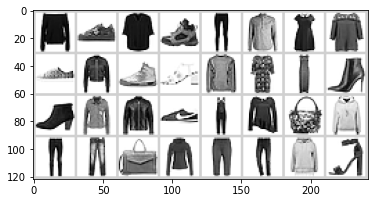

In [42]:
# create grid of images
dataiter = iter(fmnist_trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32].view(-1, 1, 28, 28).type(torch.float))

print('Data samples')
# show images
imshow(img_grid, one_channel=True)

## Define expert and gate networks

In [43]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class expert_layers(nn.Module):
    def __init__(self, num_classes, channels=1):
        super(expert_layers, self).__init__()
        self.filters = 3
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=self.filters, kernel_size=3)
        self.fc1 = nn.Linear(in_features=self.filters*13*13, out_features=512) # this is a pure linear transform
        self.fc2 = nn.Linear(in_features=512, out_features=128) # this is a pure linear transform
        
        self.out = nn.Linear(in_features=128, out_features=num_classes)
        
        self.num_classes = num_classes
        
    def forward(self, t):
        t = F.relu(self.conv1(t))
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, self.filters*13*13)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        
        self.hidden = t
        
        t = F.relu(t)

        # output
        t = F.softmax(self.out(t), dim=1)
                
        return t

In [44]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class expert_layers(nn.Module):
    def __init__(self, num_classes, channels=1):
        super(expert_layers, self).__init__()
        self.filters = 1
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=self.filters, kernel_size=3)
        self.fc1 = nn.Linear(in_features=self.filters*13*13, out_features=64) # this is a pure linear transform
        self.fc2 = nn.Linear(in_features=64, out_features=32) # this is a pure linear transform
        
        self.out = nn.Linear(in_features=32, out_features=num_classes)
        
        self.num_classes = num_classes
        
    def forward(self, t):
        t = F.relu(self.conv1(t))
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, self.filters*13*13)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
 
        self.hidden = t
        
        t = F.relu(t)

        # output
        t = F.softmax(self.out(t), dim=1)
                
        return t

In [45]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class gate_attn_layers(nn.Module):
    def __init__(self, num_experts, channels=1):
        super(gate_attn_layers, self).__init__()
        # define layers
        self.filters = 6
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=self.filters, kernel_size=3)
        self.fc1 = nn.Linear(in_features=self.filters*13*13, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=128)

    def forward(self, t, T=1.0, y=None):
        # conv 1
        t = F.relu(self.conv1(t))
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, self.filters*13*13)
            
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        return t


In [46]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class gate_attn_layers(nn.Module):
    def __init__(self, num_experts, channels=1):
        super(gate_attn_layers, self).__init__()
        # define layers
        self.filters = 8
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=self.filters, kernel_size=3)
        self.bn = nn.BatchNorm2d(self.filters)
        self.fc1 = nn.Linear(in_features=self.filters*13*13, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=num_experts)
        self.num_experts = num_experts

    def forward(self, t, T=1.0, y=None):
        # conv 1
        t = F.relu(self.bn(self.conv1(t)))
        t = F.max_pool2d(t, kernel_size=2, stride=2)
                        
        # fc1
        t = t.reshape(-1, self.filters*13*13)
            
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        return t


In [47]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class gate_layers(nn.Module):
    def __init__(self, num_experts, channels=1):
        super(gate_layers, self).__init__()
        # define layers
        self.filters = 6
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=self.filters, kernel_size=3)
        self.fc1 = nn.Linear(in_features=self.filters*13*13, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=128)
        self.out = nn.Linear(in_features=128, out_features=num_experts)
        self.num_experts = num_experts

    def forward(self, t, T=1.0, y=None):
        # conv 1
        t = F.relu(self.conv1(t))
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, self.filters*13*13)
            
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = self.out(t)
        t = F.softmax(t/T, dim=1)
        return t


In [48]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class gate_layers(nn.Module):
    def __init__(self, num_experts, channels=1):
        super(gate_layers, self).__init__()
        # define layers
        self.filters = 8
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=self.filters, kernel_size=3)
        self.bn = nn.BatchNorm2d(self.filters)
        self.fc1 = nn.Linear(in_features=self.filters*13*13, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=num_experts)
        self.num_experts = num_experts

    def forward(self, t, T=1.0, y=None):
        # conv 1
        t = F.relu(self.bn(self.conv1(t)))
        t = F.max_pool2d(t, kernel_size=2, stride=2)
                        
        # fc1
        t = t.reshape(-1, self.filters*13*13)
            
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = self.out(t)
        t = F.softmax(t/T, dim=1)
        return t


In [49]:
# create a set of experts
def experts(num_experts, num_classes, expert_layers_type=expert_layers, channels=1):
    models = []
    for i in range(num_experts):
        models.append(expert_layers_type(num_classes, channels))
    return nn.ModuleList(models)

## Initialize configurations and helper functions

In [50]:
def accuracy(out, yb, mean=True):
    preds = torch.argmax(out, dim=1).to(device, non_blocking=True)
    if mean:
        return (preds == yb).float().mean()
    else:
        return (preds == yb).float()

### NOTE: when importance is set to 0 then it is the default training without regularization

In [51]:
def train_with_attention(model_1, trainloader, testloader, runs, temps, w_importance_range=[0], 
                         w_sample_sim_same_range=[0.0], w_sample_sim_diff_range=[0.0],
                         num_classes=10, total_experts=5, num_epochs=20, channels=1):
    
    hidden = 32
    
    for T, w_importance, w_sample_sim_same, w_sample_sim_diff, in product(temps, w_importance_range,w_sample_sim_same_range,  w_sample_sim_diff_range):
        
        print('Temperature',['{:.1f}'.format(t) for t in T])
        print('w_importance','{:.1f}'.format(w_importance))
        if w_sample_sim_same < 1:
            print('w_sample_sim_same',str(w_sample_sim_same))
        else:
            print('w_sample_sim_same','{:.1f}'.format(w_sample_sim_same))
        
        if w_sample_sim_diff < 1:
            print('w_sample_sim_diff',str(w_sample_sim_diff))
        else:
            print('w_sample_sim_diff','{:.1f}'.format(w_sample_sim_diff))

        n_run_models_1 = []
        for run in range(1,runs+1):

            print('Run:', run), 

            models = {'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss(),
                                               'experts':{}},}
            for key, val in models.items():

                expert_models = experts(total_experts, num_classes, channels=channels).to(device)
                
                gate_model = gate_attn_layers(total_experts, channels).to(device)

                moe_model = val['model'](total_experts, num_classes, attention_flag=1, hidden=hidden, 
                                         experts=expert_models, gate=gate_model).to(device)
                
                optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)
                

                hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe = optimizer_moe,
                                       T = T, w_importance=w_importance, 
                                       w_sample_sim_same = w_sample_sim_same, w_sample_sim_diff = w_sample_sim_diff, 
                                       accuracy=accuracy, epochs=num_epochs)
                val['experts'][total_experts] = {'model':moe_model, 'history':hist}
            
            # Save all the trained models
            plot_file = generate_plot_file(model_1, T[0], w_importance=w_importance, 
                                           w_sample_sim_same=w_sample_sim_same,w_sample_sim_diff=w_sample_sim_diff,
                                           specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')
            
            
            if run > 1:
                n_run_models_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'))
                
            n_run_models_1.append(models)                                
            torch.save(n_run_models_1,open(os.path.join(model_path, plot_file),'wb'))
            n_run_models_1 = []
        print(plot_file)

In [52]:
def train_from_model(m, num_epochs, num_classes, total_experts, w_importance_range=[0.0], w_sample_sim_same_range=[0.0], w_sample_sim_diff_range=[0.0],
                     trainloader=None, testloader=None, expert_no_grad=True, gate_no_grad=False):
    
    T = [1.0]*num_epochs
    for w_importance, w_sample_sim_same, w_sample_sim_diff in product(w_importance_range, w_sample_sim_same_range, w_sample_sim_diff_range):
        
        print('w_importance','{:.1f}'.format(w_importance))
        
        if w_sample_sim_same < 1:
            print('w_sample_sim_same',str(w_sample_sim_same))
        else:
            print('w_sample_sim_same','{:.1f}'.format(w_sample_sim_same))
        
        if w_sample_sim_diff < 1:
            print('w_sample_sim_diff',str(w_sample_sim_diff))
        else:
            print('w_sample_sim_diff','{:.1f}'.format(w_sample_sim_diff))
        
        plot_file = generate_plot_file(m, temp=T[0], w_importance=w_importance,  
                                       w_sample_sim_same=w_sample_sim_same,w_sample_sim_diff=w_sample_sim_diff,
                                       specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

        attn_models = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)

        n_run_models_1 = []
        run = 1
        for model in attn_models: 
            print('Run:', run)
            new_expert_models = experts(total_experts, num_classes).to(device)
            old_expert_models = model['moe_expectation_model']['experts'][total_experts]['model'].experts
            for i, expert in enumerate(new_expert_models):
                old_expert = old_expert_models[i]
                expert.load_state_dict(old_expert.state_dict())
                if expert_no_grad:
                    for param in expert.parameters():
                        param.requires_grad = False

            new_gate_model = gate_layers(total_experts).to(device)
            old_gate_model = model['moe_expectation_model']['experts'][total_experts]['model'].gate
            new_gate_model.load_state_dict(old_gate_model.state_dict(), strict=False)

            if gate_no_grad:
                for param in new_gate_model.parameters():
                    param.requires_grad = False
                new_gate_model.out = nn.Linear(in_features=32, out_features=num_experts)
                
            gate_model = new_gate_model

            models = {'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss(),
                                           'experts':{}},}

            for key, val in models.items():

                # gate_model = gate_layers(total_experts).to(device)                

                moe_model = val['model'](total_experts, num_classes,
                                         experts=new_expert_models, gate= gate_model).to(device)

                optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)


                hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe = optimizer_moe,
                                       T = T, accuracy=accuracy, epochs=num_epochs)
                val['experts'][total_experts] = {'model':moe_model, 'history':hist}

            plot_file = generate_plot_file('new_'+m, T[0], w_importance=w_importance, w_sample_sim_same=w_sample_sim_same,w_sample_sim_diff=w_sample_sim_diff,
                                           specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')
        
            if run > 1:
                n_run_models_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'))
                
            n_run_models_1.append(models)                                
            torch.save(n_run_models_1,open(os.path.join(model_path, plot_file),'wb'))
            n_run_models_1 = []
            print(plot_file)
            
            run+=1


## Experiment 1: MoE model training with attention

### FMNIST data

In [53]:
# Model with gate and expert parameters initialized to default values
model_1 = 'fmnist_with_attention'

In [54]:
total_experts = 5

In [55]:
num_epochs = 20

In [56]:
temps = [[1.0]*num_epochs]
temps

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]]

In [57]:
runs = 10

In [58]:
train_with_attention(model_1, fmnist_trainloader, fmnist_testloader, runs, temps, num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
Run: 1
epoch 0 training loss 1.16 , training accuracy 0.62 , test accuracy 0.76
epoch 1 training loss 0.57 , training accuracy 0.79 , test accuracy 0.80
epoch 2 training loss 0.49 , training accuracy 0.82 , test accuracy 0.82
epoch 3 training loss 0.45 , training accuracy 0.84 , test accuracy 0.83
epoch 4 training loss 0.41 , training accuracy 0.85 , test accuracy 0.84
epoch 5 training loss 0.38 , training accuracy 0.86 , test accuracy 0.84
epoch 6 training loss 0.36 , training accuracy 0.87 , test accuracy 0.85
epoch 7 training loss 0.35 , training accuracy 0.87 , test accuracy 0.85
epoch 8 training loss 0.33 , training accuracy 0.88 , test accuracy 0.86
epoch 9 training loss 0.31 , training accuracy 0.89 , test accuracy 0.86
epoch 10 training loss 0.30 , training accuracy 0

### Combined FMNIST MNIST data

In [75]:
# Model with gate and expert parameters initialized to default values
model_1 = 'fmnist_mnist_with_attention_hidden_32'

In [76]:
total_experts = 6

In [77]:
num_epochs = 20

In [78]:
temps = [[1.0]*num_epochs]
temps

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]]

In [79]:
runs = 10

In [80]:
train_with_attention(model_1, fmnist_mnist_trainloader, fmnist_mnist_testloader, runs, temps, num_classes=num_classes_fmnist_mnist, total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
Run: 0
epoch 0 training loss 1.42 , training accuracy 0.62 , test accuracy 0.77
epoch 1 training loss 0.50 , training accuracy 0.84 , test accuracy 0.84
epoch 2 training loss 0.39 , training accuracy 0.88 , test accuracy 0.85
epoch 3 training loss 0.33 , training accuracy 0.89 , test accuracy 0.88
epoch 4 training loss 0.30 , training accuracy 0.90 , test accuracy 0.88
epoch 5 training loss 0.28 , training accuracy 0.91 , test accuracy 0.88
epoch 6 training loss 0.27 , training accuracy 0.91 , test accuracy 0.88
epoch 7 training loss 0.25 , training accuracy 0.92 , test accuracy 0.89
epoch 8 training loss 0.23 , training accuracy 0.92 , test accuracy 0.89
epoch 9 training loss 0.23 , training accuracy 0.92 , test accuracy 0.89
epoch 10 training loss 0.22 , training accuracy 0.93 , test accuracy 0.89
epoch 11 training l

## Experiment 2: MoE model training with attention and gate regularization

### FMNIST data

In [59]:
# Model with gate and expert parameters initialized to default values
model_2 = 'fmnist_with_attn_reg'

In [60]:
total_experts = 5

In [61]:
num_epochs = 20

In [62]:
temps = [[1.0]*num_epochs]
temps

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]]

In [63]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
w_importance_range

[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]

In [64]:
runs = 10

In [65]:
train_with_attention(model_2, fmnist_trainloader, fmnist_testloader, runs, temps, w_importance_range, 
                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.2
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
Run: 1
epoch 0 training loss 1.18 , training accuracy 0.62 , test accuracy 0.75
epoch 1 training loss 0.53 , training accuracy 0.81 , test accuracy 0.81
epoch 2 training loss 0.42 , training accuracy 0.85 , test accuracy 0.85
epoch 3 training loss 0.38 , training accuracy 0.87 , test accuracy 0.86
epoch 4 training loss 0.34 , training accuracy 0.88 , test accuracy 0.86
epoch 5 training loss 0.31 , training accuracy 0.89 , test accuracy 0.87
epoch 6 training loss 0.30 , training accuracy 0.90 , test accuracy 0.88
epoch 7 training loss 0.27 , training accuracy 0.91 , test accuracy 0.88
epoch 8 training loss 0.26 , training accuracy 0.91 , test accuracy 0.88
epoch 9 training loss 0.24 , training accuracy 0.92 , test accuracy 0.88
epoch 10 training loss 0.23 , training accuracy 0

### Combined FMNIST MNIST data

In [88]:
# Model with gate and expert parameters initialized to default values
model_2 = 'fmnist_mnist_with_attn_reg_hidden_32'

In [89]:
total_experts = 6

In [90]:
num_epochs = 20

In [91]:
temps = [[1.0]*num_epochs]
temps

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]]

In [92]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
w_importance_range

[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]

In [93]:
runs = 10

In [94]:
train_with_attention(model_2, fmnist_mnist_trainloader, fmnist_mnist_testloader, runs, temps=temps, w_importance_range=w_importance_range, 
                     num_classes=num_classes_fmnist_mnist, total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.2
Run: 0
epoch 0 training loss 1.48 , training accuracy 0.58 , test accuracy 0.74
epoch 1 training loss 0.57 , training accuracy 0.82 , test accuracy 0.82
epoch 2 training loss 0.41 , training accuracy 0.87 , test accuracy 0.87
epoch 3 training loss 0.34 , training accuracy 0.89 , test accuracy 0.87
epoch 4 training loss 0.29 , training accuracy 0.91 , test accuracy 0.90
epoch 5 training loss 0.26 , training accuracy 0.92 , test accuracy 0.88
epoch 6 training loss 0.25 , training accuracy 0.92 , test accuracy 0.89
epoch 7 training loss 0.22 , training accuracy 0.93 , test accuracy 0.90
epoch 8 training loss 0.22 , training accuracy 0.93 , test accuracy 0.90
epoch 9 training loss 0.20 , training accuracy 0.94 , test accuracy 0.91
epoch 10 training loss 0.19 , training accuracy 0.94 , test accuracy 0.90
epoch 11 training l

## Experiment 3: MoE model training with attention and sample similarity regularization

### FMNIST data

In [66]:
# Model with gate and expert parameters initialized to default values
model_2 = 'fmnist_with_attn_reg'

In [67]:
total_experts = 5

In [68]:
num_epochs = 20

In [69]:
temps = [[1.0]*num_epochs]
temps

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]]

In [70]:
w_sample_sim_same_range = [1e-7, 1e-6]
w_sample_sim_diff_range = [1e-7, 1e-6, 1e-5,1e-4,1e-3,1e-2,1e-1]
w_sample_sim_same_range, w_sample_sim_diff_range

([1e-07, 1e-06], [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1])

In [71]:
runs = 10

In [72]:
train_with_attention(model_2, fmnist_trainloader, fmnist_testloader, runs, temps, 
                     w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range, 
                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_sample_sim_same 1e-07
w_sample_sim_diff 1e-07
Run: 1
epoch 0 training loss 1.14 , training accuracy 0.67 , test accuracy 0.78
epoch 1 training loss 0.54 , training accuracy 0.82 , test accuracy 0.83
epoch 2 training loss 0.45 , training accuracy 0.85 , test accuracy 0.84
epoch 3 training loss 0.41 , training accuracy 0.86 , test accuracy 0.85
epoch 4 training loss 0.38 , training accuracy 0.87 , test accuracy 0.86
epoch 5 training loss 0.36 , training accuracy 0.88 , test accuracy 0.86
epoch 6 training loss 0.34 , training accuracy 0.89 , test accuracy 0.86
epoch 7 training loss 0.33 , training accuracy 0.89 , test accuracy 0.87
epoch 8 training loss 0.31 , training accuracy 0.90 , test accuracy 0.87
epoch 9 training loss 0.30 , training accuracy 0.90 , test accuracy 0.88
epoch 10 training loss 0.28 , training accura

## Retrain model without attention

In [166]:
m = 'fmnist_with_attn_reg'

total_experts = 5
num_classes = 10
num_epochs = 20

w_importance_range = [i * 0.2 for i in range(1, 6)]


train_from_model(m, num_epochs, num_classes, total_experts, w_importance_range=w_importance_range, trainloader=fmnist_trainloader, testloader=fmnist_testloader)

w_importance 0.2
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
Run: 1
epoch 0 training loss 0.39 , training accuracy 0.88 , test accuracy 0.88
epoch 1 training loss 0.21 , training accuracy 0.93 , test accuracy 0.90
epoch 2 training loss 0.19 , training accuracy 0.93 , test accuracy 0.89
epoch 3 training loss 0.17 , training accuracy 0.94 , test accuracy 0.90
epoch 4 training loss 0.16 , training accuracy 0.94 , test accuracy 0.89
epoch 5 training loss 0.15 , training accuracy 0.95 , test accuracy 0.90
epoch 6 training loss 0.15 , training accuracy 0.95 , test accuracy 0.90
epoch 7 training loss 0.14 , training accuracy 0.95 , test accuracy 0.90
epoch 8 training loss 0.14 , training accuracy 0.95 , test accuracy 0.90
epoch 9 training loss 0.13 , training accuracy 0.95 , test accuracy 0.90
epoch 10 training loss 0.13 , training accuracy 0.95 , test accuracy 0.89
epoch 11 training loss 0.13 , training accuracy 0.95 , test accuracy 0.90
epoch 12 training loss 0.13 , training accuracy 0.95 ,

In [167]:
m = 'fmnist_with_attn_reg'

total_experts = 5
num_classes = 10
num_epochs = 20

w_sample_sim_same_range = [1e-7, 1e-6]
w_sample_sim_diff_range = [1e-7, 1e-6, 1e-5,1e-4,1e-3,1e-2,1e-1]


train_from_model(m, num_epochs, num_classes, total_experts, w_sample_sim_same_range=w_sample_sim_same_range,w_sample_sim_diff_range=w_sample_sim_diff_range,
                 trainloader=fmnist_trainloader, testloader=fmnist_testloader)

w_importance 0.0
w_sample_sim_same 1e-07
w_sample_sim_diff 1e-07
Run: 1
epoch 0 training loss 0.35 , training accuracy 0.88 , test accuracy 0.89
epoch 1 training loss 0.21 , training accuracy 0.93 , test accuracy 0.89
epoch 2 training loss 0.18 , training accuracy 0.93 , test accuracy 0.89
epoch 3 training loss 0.17 , training accuracy 0.94 , test accuracy 0.90
epoch 4 training loss 0.15 , training accuracy 0.94 , test accuracy 0.89
epoch 5 training loss 0.15 , training accuracy 0.95 , test accuracy 0.90
epoch 6 training loss 0.14 , training accuracy 0.95 , test accuracy 0.90
epoch 7 training loss 0.14 , training accuracy 0.95 , test accuracy 0.89
epoch 8 training loss 0.13 , training accuracy 0.95 , test accuracy 0.89
epoch 9 training loss 0.13 , training accuracy 0.95 , test accuracy 0.89
epoch 10 training loss 0.13 , training accuracy 0.95 , test accuracy 0.90
epoch 11 training loss 0.12 , training accuracy 0.95 , test accuracy 0.90
epoch 12 training loss 0.12 , training accuracy 0.

## Results

### Collect results

In [53]:
def expert_usage_entropy(history, total_experts=5, num_epochs=20):
    gate_probability = torch.vstack(history['gate_probabilities']).view(num_epochs, -1, total_experts)
    gate_probabilities_sum = torch.mean(gate_probability[-1,:,:].view(-1, total_experts), dim=0)
    return entropy(gate_probabilities_sum).item()

In [55]:
import csv
from helper import moe_models

def collect_results(m, temps=[1.0], w_importance_range=[0.0], w_ortho_range=[0.0], 
                    w_sample_sim_same_range=[0.0], w_sample_sim_diff_range=[0.0],
                    total_experts=5, num_classes=10, num_epochs=20, 
                    testloader=None, fig_path=None, model_path=None, filename='fmnist_results.csv'):
    
    if os.path.exists(filename):
        p = 'a'
    else:
        p = 'w'
        
    header = ['filename', 'train error', 'val error','mutual information', 'sample entropy', 'experts usage']
    
    with open(filename, p) as f:
                
        writer = csv.writer(f)        
        
        if p == 'w':            
            writer.writerow(header)
        
        for w_importance, w_sample_sim_same, w_sample_sim_diff in product(w_importance_range, w_sample_sim_same_range, w_sample_sim_diff_range):
            plot_file = generate_plot_file(m, w_importance=w_importance, w_sample_sim_same=w_sample_sim_same, w_sample_sim_diff=w_sample_sim_diff, 
                                           specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

            models = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
            for _ in range(len(models)):
                mod = models.pop()
                data = [plot_file]
                model = mod['moe_expectation_model']['experts'][total_experts]['model']
                history = mod['moe_expectation_model']['experts'][total_experts]['history']
                data.append(1-history['accuracy'][-1].item())
                running_test_accuracy = 0.0
                running_entropy = 0.0
                num_batches = 0
                ey =  torch.zeros((num_classes, total_experts)).to(device)
                for test_inputs, test_labels in testloader:
                    test_inputs, test_labels = test_inputs.to(device, non_blocking=True), test_labels.to(device, non_blocking=True)                
                    outputs = model(test_inputs)
                    running_test_accuracy += accuracy(outputs, test_labels)
                    
                    selected_experts = torch.argmax(model.gate_outputs, dim=1)
                    y = test_labels
                    e = selected_experts
                    for j in range(y.shape[0]):
                        ey[int(torch.argmax(model.expert_outputs[j,e[j],:])), int(e[j])] += 1

                    running_entropy += moe_models.entropy(model.gate_outputs)
                    
                    num_batches+=1
 
                mutual_EY,_,_,_ = moe_models.mutual_information(ey.detach())
    
                val_error = 1-(running_test_accuracy/num_batches)
                data.append(val_error.item())
                data.append(mutual_EY.item())
                
                data.append(running_entropy.item()/num_batches)
                gate_probabilities_sum = torch.mean(model.gate_outputs, dim=0)            
                data.append(entropy(gate_probabilities_sum).item())
                
                writer.writerow(data)
            
            

In [56]:
total_experts = 5
num_classes = 10
num_epochs = 20

In [57]:
m = 'fmnist_without_reg'
collect_results(m, total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=fmnist_testloader, model_path=model_path)

In [58]:
m = 'fmnist_with_reg'
w_importance_range = [i * 0.2 for i in range(1, 6)]
collect_results(m, w_importance_range=w_importance_range,
                total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=fmnist_testloader, model_path=model_path)

In [59]:
m = 'fmnist_with_reg'
w_sample_sim_same_range = [1e-7, 1e-6]
w_sample_sim_diff_range = [1e-7, 1e-6, 1e-5,1e-4,1e-3,1e-2,1e-1]
collect_results(m, w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range,
                total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=fmnist_testloader, model_path=model_path)

In [60]:
m = 'fmnist_with_attention'
collect_results(m, total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=fmnist_testloader, model_path=model_path)

In [61]:
m = 'fmnist_with_attn_reg'
w_importance_range = [i * 0.2 for i in range(1, 6)]
collect_results(m, w_importance_range=w_importance_range,
                total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=fmnist_testloader, model_path=model_path)

In [62]:
m = 'fmnist_with_attn_reg'
w_sample_sim_same_range = [1e-7, 1e-6]
w_sample_sim_diff_range = [1e-7, 1e-6, 1e-5,1e-4,1e-3,1e-2,1e-1]
collect_results(m, w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range,
                total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=fmnist_testloader, model_path=model_path)

In [63]:
m = 'new_fmnist_with_attn_reg'
w_importance_range = [i * 0.2 for i in range(1, 6)]
collect_results(m, w_importance_range=w_importance_range,
                total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=fmnist_testloader, model_path=model_path)

In [64]:
m = 'new_fmnist_with_attn_reg'
w_sample_sim_same_range = [1e-7, 1e-6]
w_sample_sim_diff_range = [1e-7, 1e-6, 1e-5,1e-4,1e-3,1e-2,1e-1]
collect_results(m, w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range,
                total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=fmnist_testloader, model_path=model_path)

In [38]:
m = 'fmnist_mnist_pretrained_gate_prechosen_full_data'
collect_results(m, total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=fmnist_testloader, model_path=model_path)

### Final results

In [66]:
import pandas as pd
filename = 'fmnist_results.csv'
data = pd.read_csv(filename)

In [67]:
final_results_filename = 'fmnist_final_results.csv'

In [68]:
models = ['fmnist_single_model', 'fmnist_without_reg', 'fmnist_with_reg_importance', 
          'fmnist_with_reg_sample', 'fmnist_with_attention', 'fmnist_with_attn_reg_importance',
          'fmnist_with_attn_reg_sample', 'new_fmnist_with_attn_reg_importance',
          'new_fmnist_with_attn_reg_sample']
header = True
for i, m in enumerate(models):
    if i:
        header = False
    row = data.loc[[data[data['filename'].str.startswith(m)]['train error'].idxmin()]]
    std = '{:.3f}'.format(data[data['filename'].str.startswith(m)]['val error'].std())
    row['val error std'] = std
    row.to_csv(final_results_filename,mode='a',header=header, index=False, float_format='%.3f')

In [69]:
data = pd.read_csv(final_results_filename)
data.fillna('NA', inplace=True)
data

,filename,train error,val error,mutual information,sample entropy,experts usage,val error std
0,fmnist_single_model_7,0.115,0.132,NA,NA,NA,0.011
1,fmnist_without_reg_10_5_models.pt,0.041,0.104,2.034,0.081,2.048,0.006
2,fmnist_with_reg_importance_0.2_10_5_models.pt,0.031,0.103,2.301,0.172,2.321,0.006
3,fmnist_with_reg_sample_sim_same_1e-07_sample_s...,0.018,0.095,2.198,0.11,2.225,0.007
4,fmnist_with_attention_10_5_models.pt,0.041,0.098,2.071,0.114,2.249,0.013
5,fmnist_with_attn_reg_importance_0.8_10_5_model...,0.014,0.098,2.233,0.101,2.319,0.006
6,fmnist_with_attn_reg_sample_sim_same_1e-06_sam...,0.014,0.096,2.296,0.109,2.321,0.008
7,new_fmnist_with_attn_reg_importance_1.0_10_5_m...,0.004,0.087,2.227,0.101,2.318,0.007
8,new_fmnist_with_attn_reg_sample_sim_same_1e-06...,0.005,0.089,2.304,0.076,2.321,0.008


In [35]:
filename = 'results.csv'
data = pd.read_csv(filename)

In [36]:
final_results_file = 'final_results_avg.csv'

In [37]:
models = ['fmnist_single_model', 'fmnist_without_reg', 'fmnist_with_reg_importance', 
          'fmnist_with_reg_sample', 'fmnist_with_attention', 'fmnist_with_attn_reg_importance',
          'fmnist_with_attn_reg_sample', 'new_fmnist_with_attn_reg_importance',
          'new_fmnist_with_attn_reg_sample']
header = True
for i, m in enumerate(models):
    if i:
        header = False
    row = data[data['filename'].str.startswith(m)].mean(numeric_only=True).to_frame().T
    std = '{:.4f}'.format(data[data['filename'].str.startswith(m)]['val error'].std())
    row.insert(0,'filename',m)
    row['val error std'] = std
    row.to_csv(final_results_file, mode='a', header=header, index=False, float_format='%.2f')

In [38]:
data = pd.read_csv(final_results_file)
data.fillna('NA', inplace=True)
data

,filename,val error,mutual information,sample entropy,experts usage,val error std
0,fmnist_single_model,0.15,NA,NA,NA,0.0109
1,fmnist_without_reg,0.11,2.06,0.09,2.13,0.0059
2,fmnist_with_reg_importance,0.10,1.83,0.46,2.32,0.0059
3,fmnist_with_reg_sample,0.11,2.11,0.12,2.26,0.0068
4,fmnist_with_attention,0.11,1.84,0.09,2.01,0.0131
5,fmnist_with_attn_reg_importance,0.10,2.23,0.1,2.32,0.0064
6,fmnist_with_attn_reg_sample,0.11,2.13,0.08,2.26,0.0076
7,new_fmnist_with_attn_reg_importance,0.10,2.22,0.07,2.31,0.0065
8,new_fmnist_with_attn_reg_sample,0.11,2.13,0.06,2.25,0.0077


### Expert Usage

Min Validation Error 0.084
Mutual Information 2.128
Sample Entropy 0.026
Expert Usage 2.250
new_fmnist_with_attn_reg_sample_sim_same_1e-07_sample_sim_diff_1e-06_10_5_models.pt


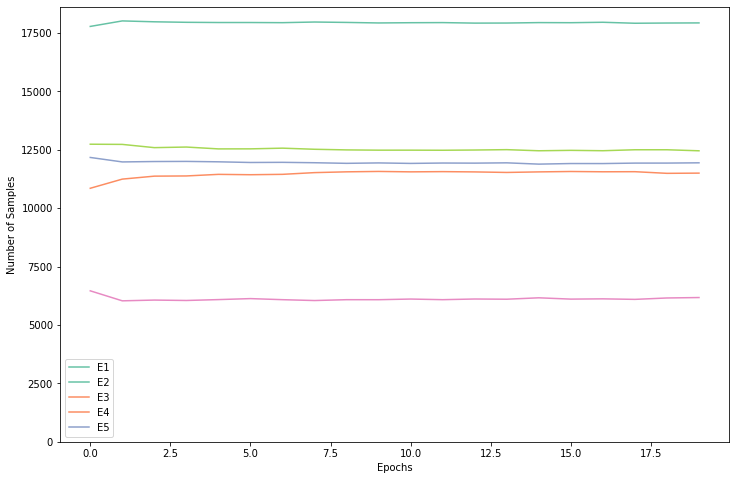

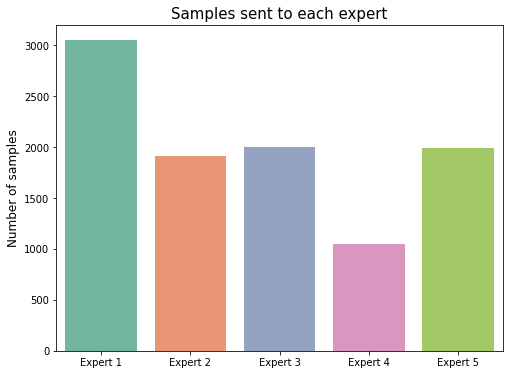

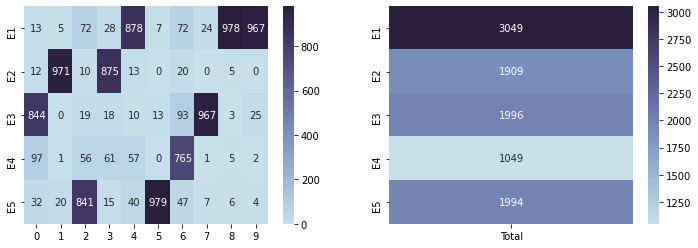


Experts used by the gate for classification of each digit


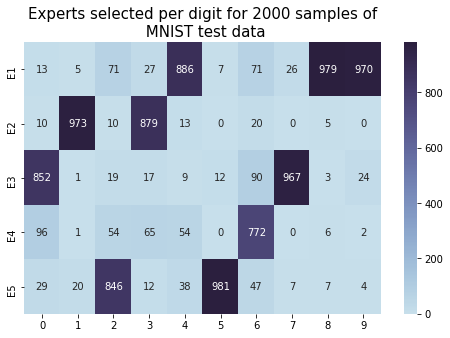

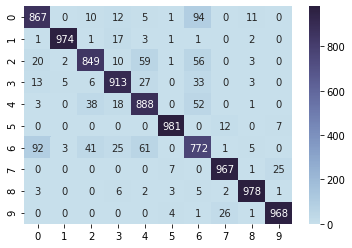

In [102]:
m = 'new_fmnist_with_attn_reg'
test_loader = fmnist_testloader
w_sample_sim_same_range = [1e-7]
w_sample_sim_diff_range = [1e-6]
plot_expert_usage(m, test_loader, w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range,
                  classes=range(10), fig_path=fig_path, model_path=model_path )

Min Validation Error 0.092
Mutual Information 1.646
Sample Entropy 0.086
Expert Usage 1.941
fmnist_without_reg_10_5_models.pt


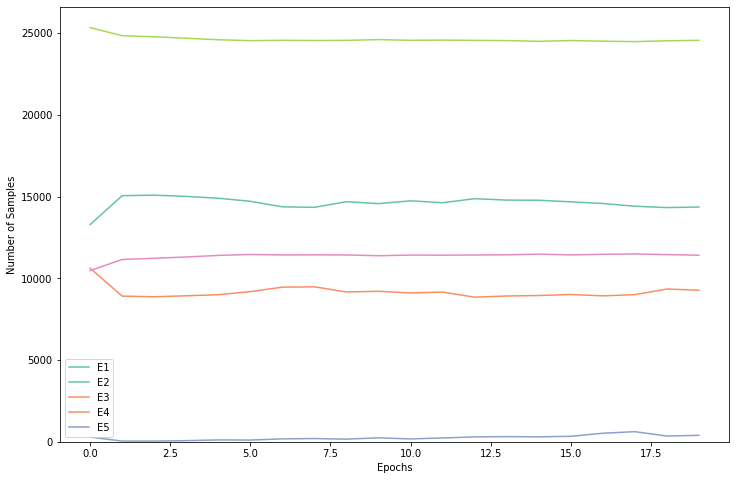

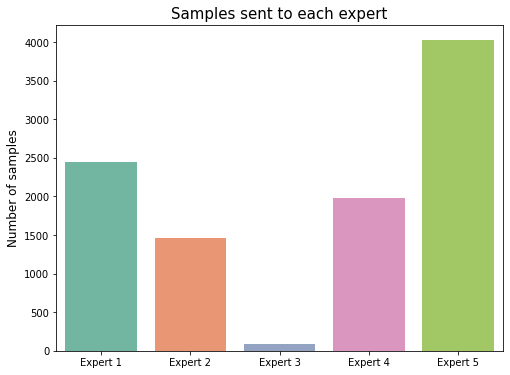

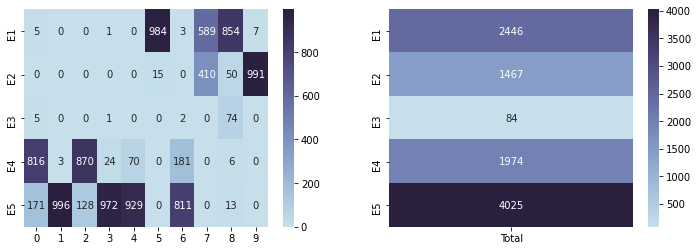


Experts used by the gate for classification of each digit


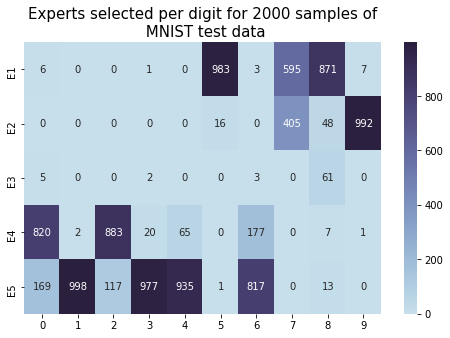

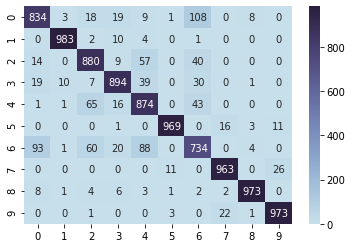

In [25]:
m = 'fmnist_without_reg'
test_loader = fmnist_testloader
w_importance_range = [0.0]
plot_expert_usage(m, test_loader, w_importance_range=w_importance_range,classes=range(10),fig_path=fig_path, model_path=model_path )

Min Validation Error 0.090
Mutual Information 1.319
Sample Entropy 0.086
Expert Usage 1.677
fmnist_with_attention_10_5_models.pt


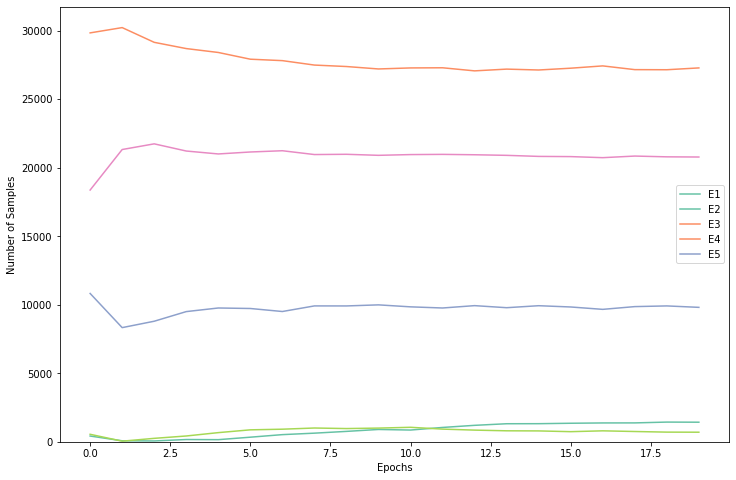

AttributeError: 'gate_attn_layers' object has no attribute 'bn'

In [154]:
m = 'fmnist_with_attention'
test_loader = fmnist_testloader
w_importance_range = [0.0]
plot_expert_usage(m, test_loader, w_importance_range=w_importance_range,classes=range(10),fig_path=fig_path, model_path=model_path )

Min Validation Error 0.115
Mutual Information 2.205
Sample Entropy 0.059
Expert Usage 2.246
fmnist_with_attention_test_10_5_models.pt


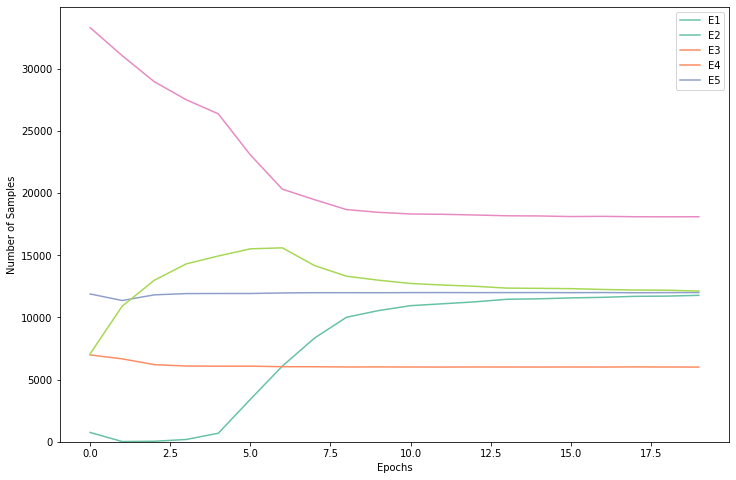

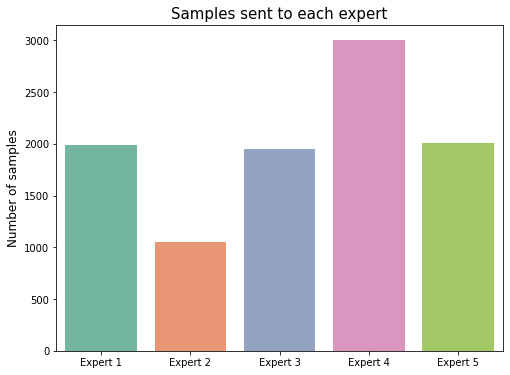

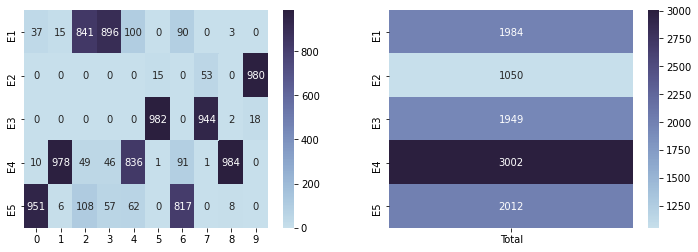


Experts used by the gate for classification of each digit


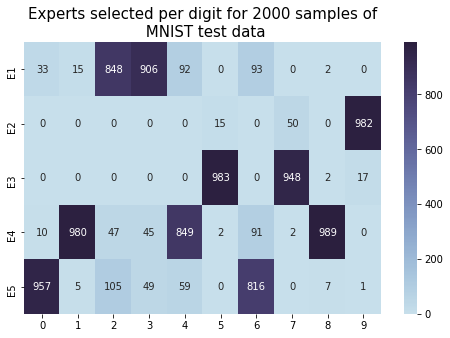

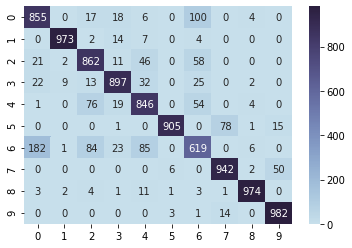

In [153]:
m = 'fmnist_with_attention_test'
test_loader = fmnist_testloader
w_importance_range = [0.0]
plot_expert_usage(m, test_loader, w_importance_range=w_importance_range,classes=range(10),fig_path=fig_path, model_path=model_path )

Min Validation Error 0.092
Mutual Information 2.009
Sample Entropy 0.047
Expert Usage 2.318
fmnist_with_attn_reg_sample_sim_same_1e-06_sample_sim_diff_0.1_10_5_models.pt


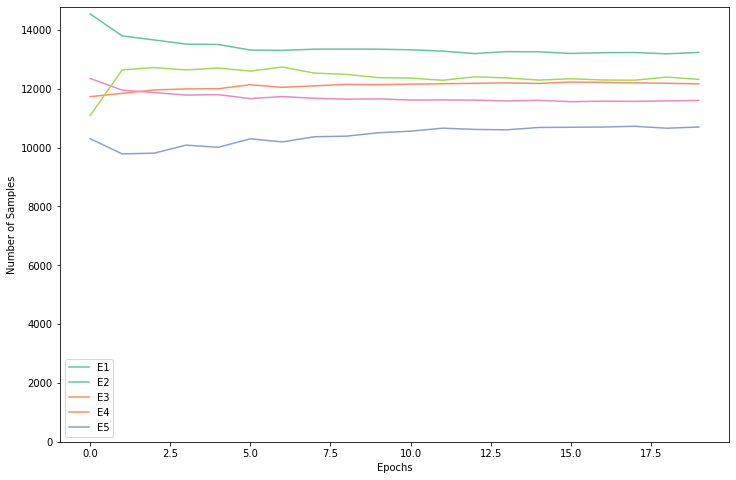

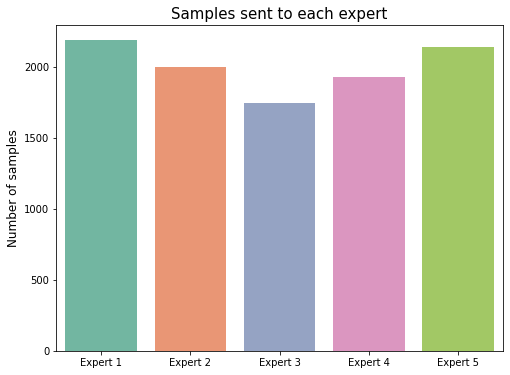

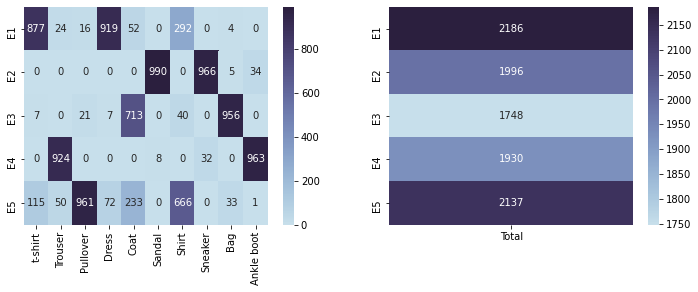


Experts used by the gate for classification of each digit


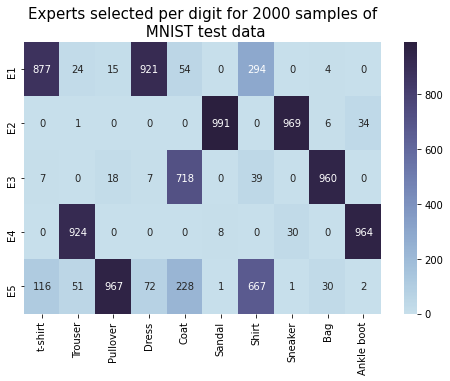

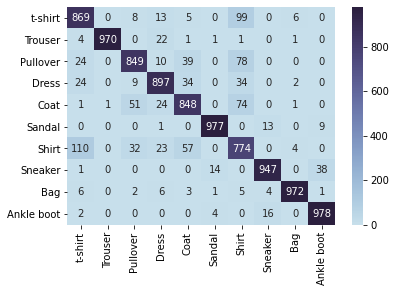

In [28]:
m = 'fmnist_with_attn_reg'
test_loader = fmnist_testloader
w_sample_sim_same_range = [1e-6, 1e-5]
w_sample_sim_diff_range = [1e-6, 1e-5,1e-4,1e-3,1e-2,1e-1]
plot_expert_usage(m, test_loader, w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range,
                  classes=classes_fmnist,fig_path=fig_path, model_path=model_path )

Min Validation Error 0.090
Mutual Information 1.835
Sample Entropy 0.140
Expert Usage 2.322
fmnist_with_attn_reg_importance_0.6_10_5_models.pt


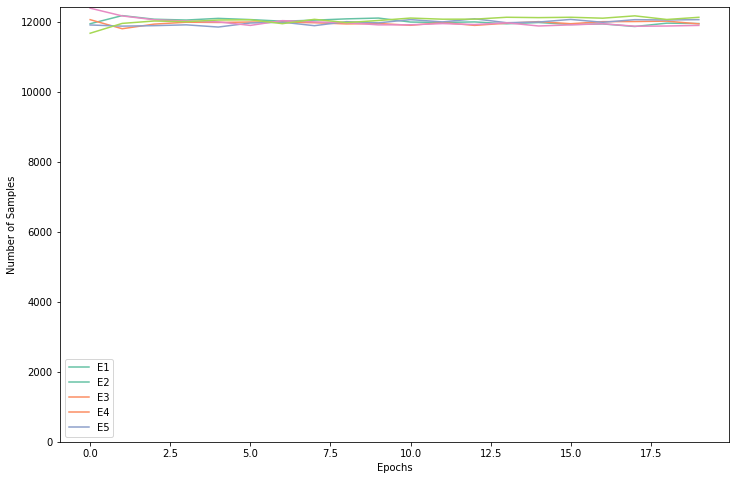

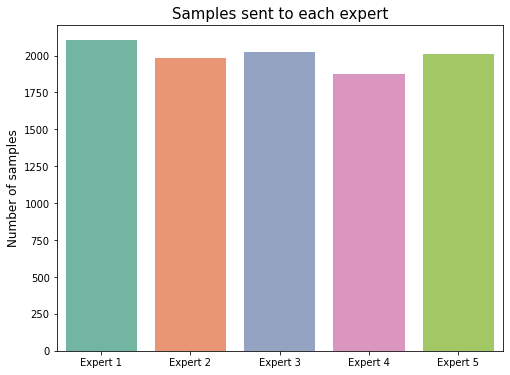

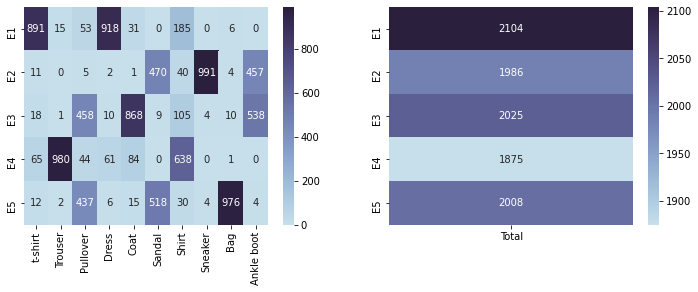


Experts used by the gate for classification of each digit


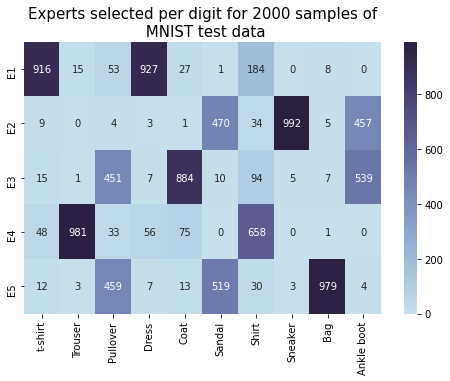

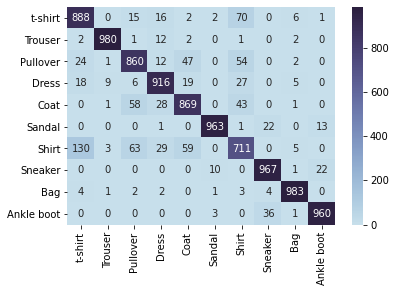

In [29]:
m = 'fmnist_with_attn_reg'
test_loader = fmnist_testloader
w_importance_range = [i * 0.2 for i in range(1, 6)]
plot_expert_usage(m, test_loader, w_importance_range=w_importance_range,num_classes=num_classes, classes=classes_fmnist,
                  fig_path=fig_path, model_path=model_path )

### Boxplots to compare multiple runs of different models

In [88]:
m = 'mnist_with_attn_reg_hidden_32'
# m = 'mnist_with_attention_hidden_32'
# m = 'mnist_with_reg_hidden_32'
# m = 'mnist_without_reg_hidden_32'
w_importance_range = [0.0]
w_importance_range = [i * 0.2 for i in range(1, 6)]
model, model_name = find_best_model(m, temps=[1.0], w_importance_range=w_importance_range, 
                    total_experts=5, num_classes=10, model_path=model_path)
model['moe_expectation_model']['experts'][total_experts]['history']['gate_probabilities'][0].shape

Min Validation Error 0.023


torch.Size([60000, 5])

<Figure size 432x288 with 0 Axes>

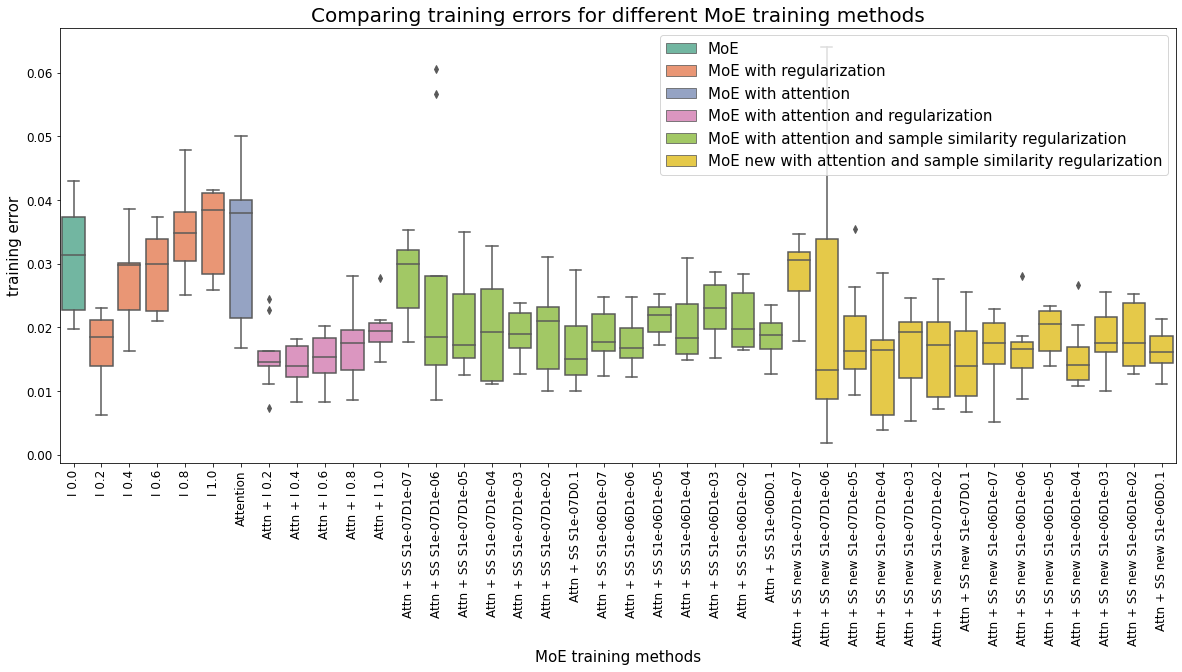

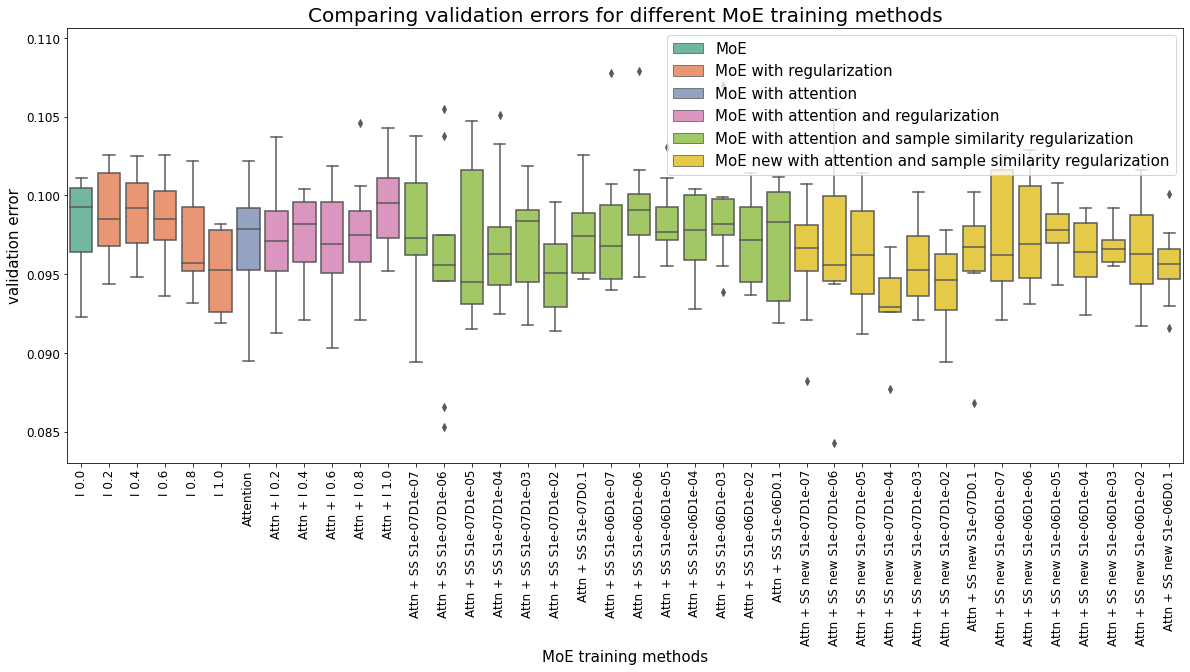

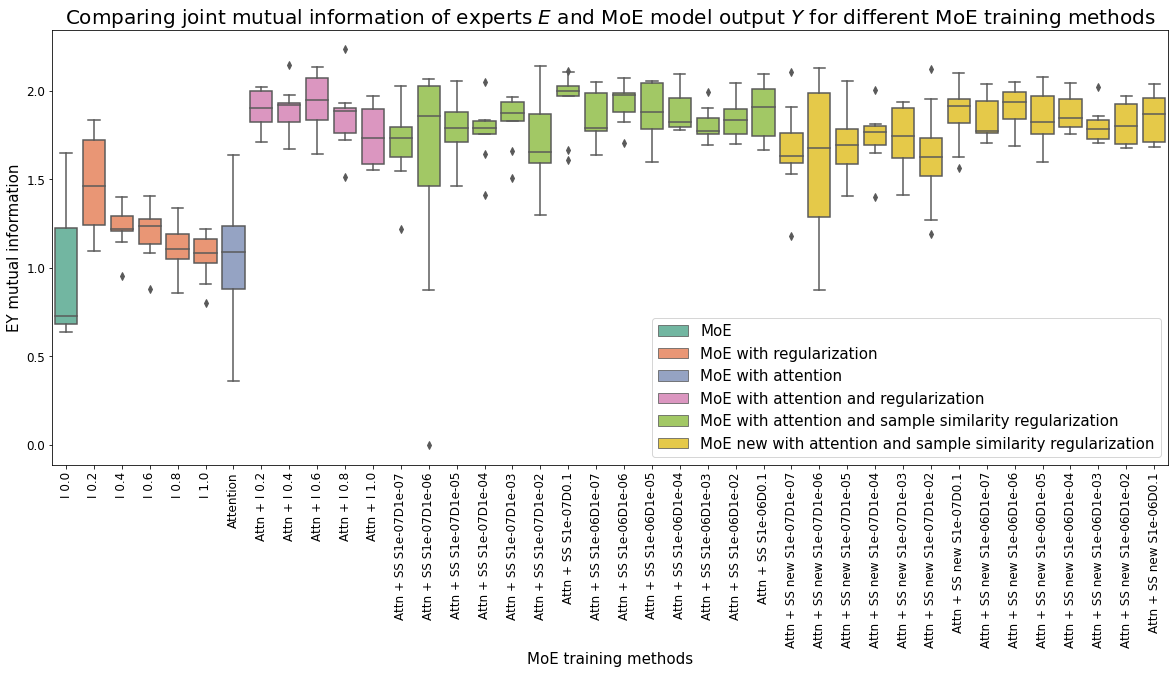

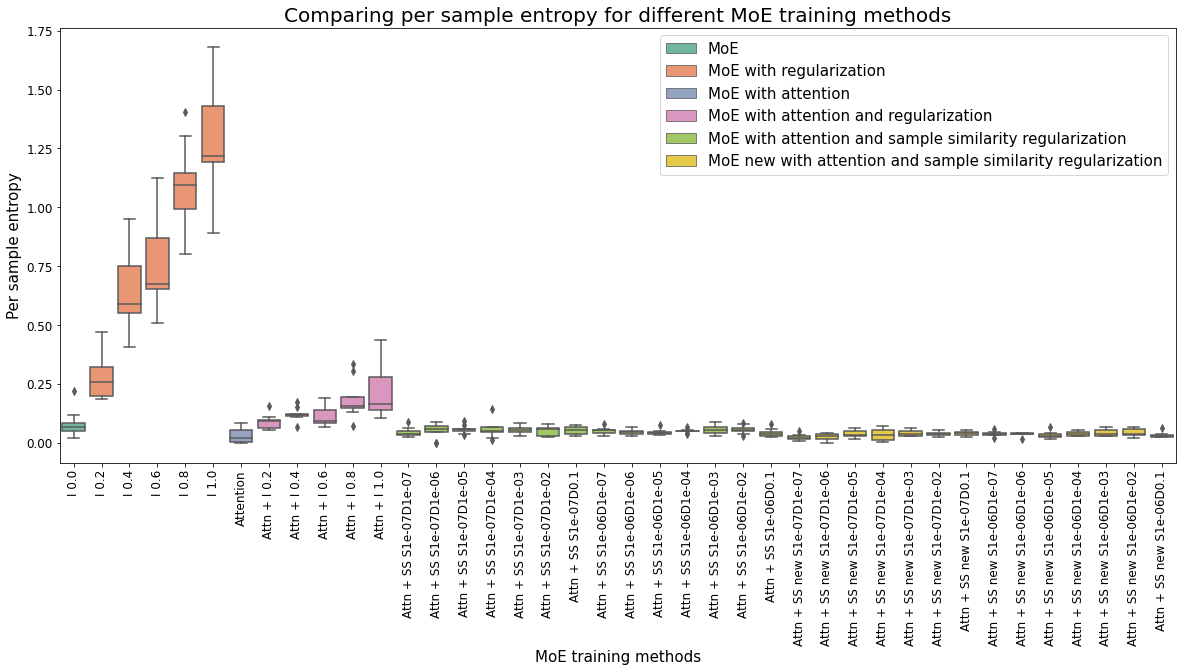

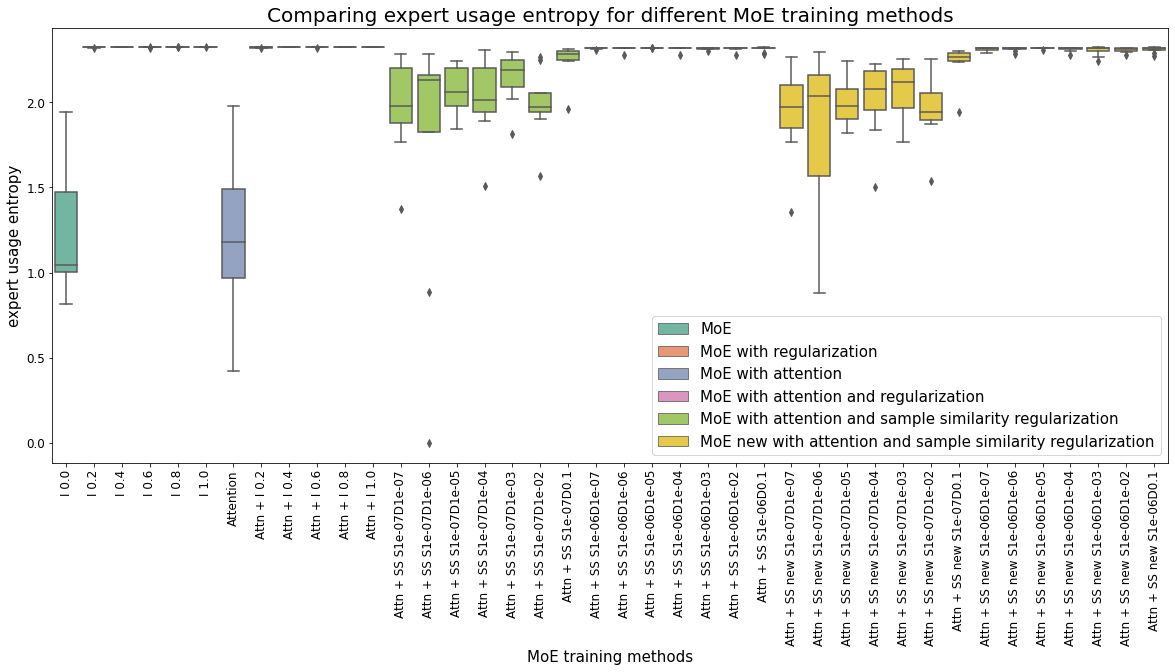

In [37]:
model_with_attention = {'ignore':'fmnist_with_attention'}
model_with_attn_reg = {'ignore':'fmnist_with_attn_reg'}
model_with_attn_sample_sim_reg = {'ignore':'fmnist_with_attn_reg', 'new':'new_fmnist_with_attn_reg'}
model_with_reg = {'ignore':'fmnist_with_reg'}
model_without_reg = {'ignore':'fmnist_without_reg'}

figname='fmnist_with_attention_hidden_32' 

total_experts = 5
num_classes = 10

w_importance_range = [i * 0.2 for i in range(1, 6)]

w_sample_sim_same_range = [1e-7, 1e-6]
w_sample_sim_diff_range = [1e-7, 1e-6, 1e-5,1e-4,1e-3,1e-2,1e-1]

boxplot(model_with_reg=model_with_reg, model_without_reg=model_without_reg, model_with_attention=model_with_attention, model_with_attn_reg=model_with_attn_reg,
        model_with_attn_sample_sim_reg = model_with_attn_sample_sim_reg,
        w_importance_range=w_importance_range, w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range,
        total_experts=total_experts, num_classes=num_classes, classes=classes_fmnist, 
        testloader=fmnist_testloader, figname=figname , fig_path=fig_path, model_path=model_path)

[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]
[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]


<Figure size 432x288 with 0 Axes>

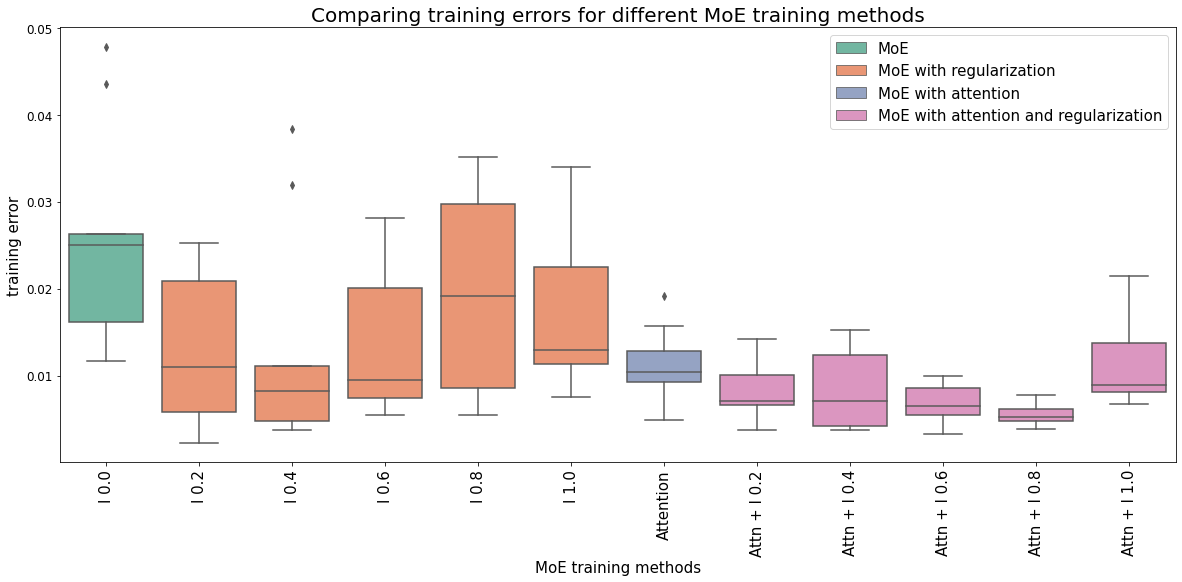

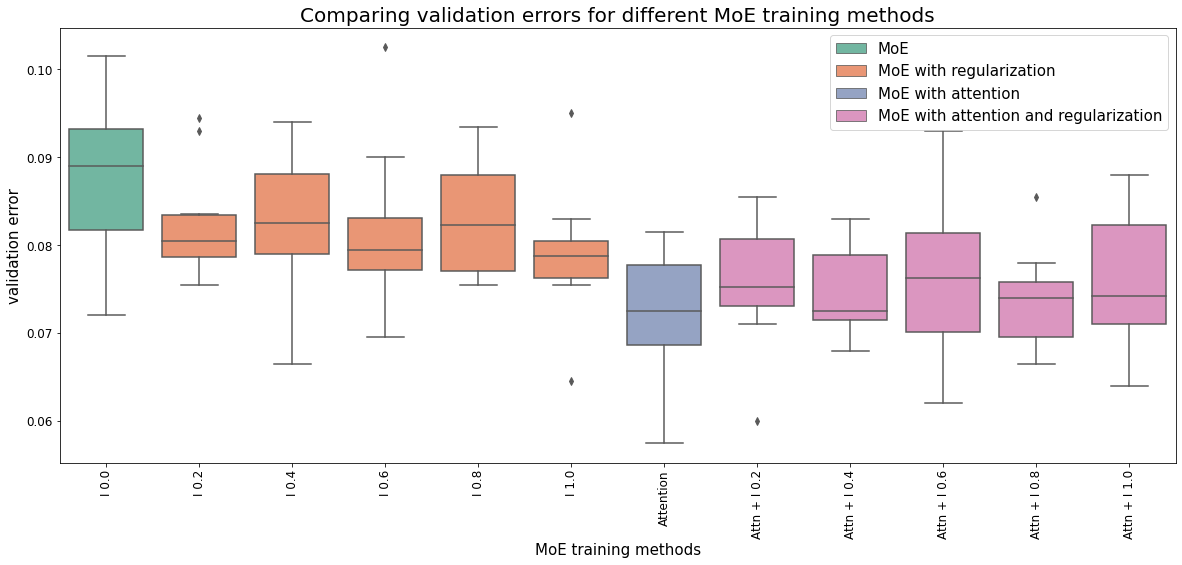

TypeError: unsupported operand type(s) for +=: 'NoneType' and 'str'

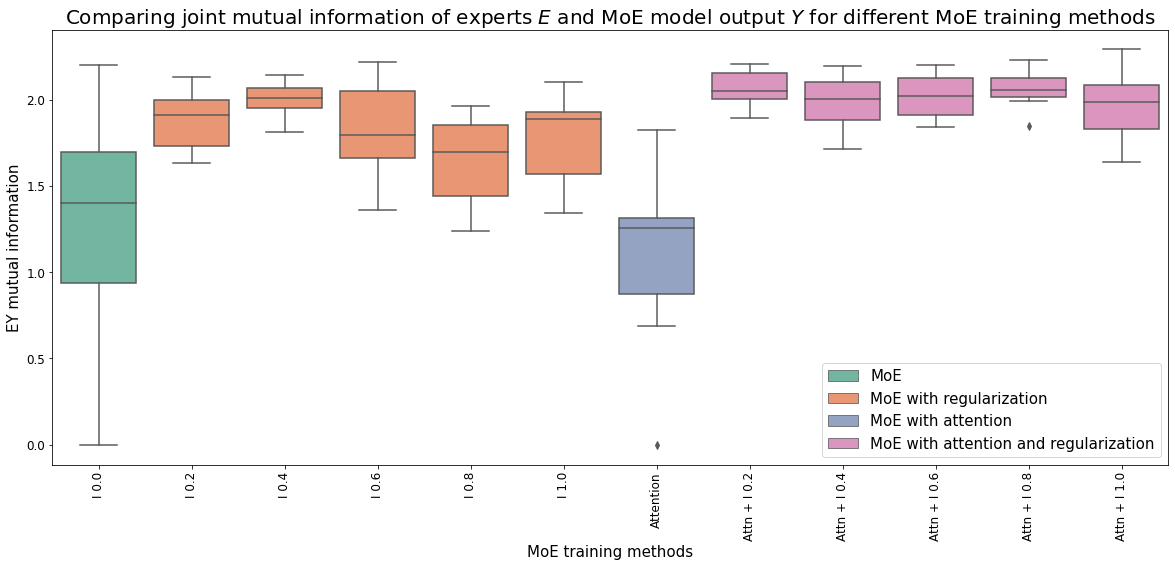

In [86]:
# model_single = 'mnist_single_model_hidden_32'
model_without_reg =  'mnist_without_reg_hidden_32'
model_with_reg = 'mnist_with_reg_hidden_32'
model_with_attention = 'mnist_with_attention_hidden_32'
model_with_attn_reg = 'mnist_with_attn_reg_hidden_32'

total_experts = 5
num_classes = 10
num_epochs = 20

temps = [[1.0]*num_epochs]
print(temps)
w_importance_range = [i * 0.2 for i in range(1, 6)]
print(w_importance_range)

boxplot(model_with_reg=model_with_reg, 
        model_without_reg=model_without_reg, 
        model_with_attention=model_with_attention, 
        model_with_attn_reg=model_with_attn_reg,
        temps=temps, w_importance_range=w_importance_range,
        total_experts=total_experts, num_classes=num_classes, classes=range(num_classes), testloader=testloader)


[1.1 1.2 1.3 1.4 1.5]
[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]


<Figure size 432x288 with 0 Axes>

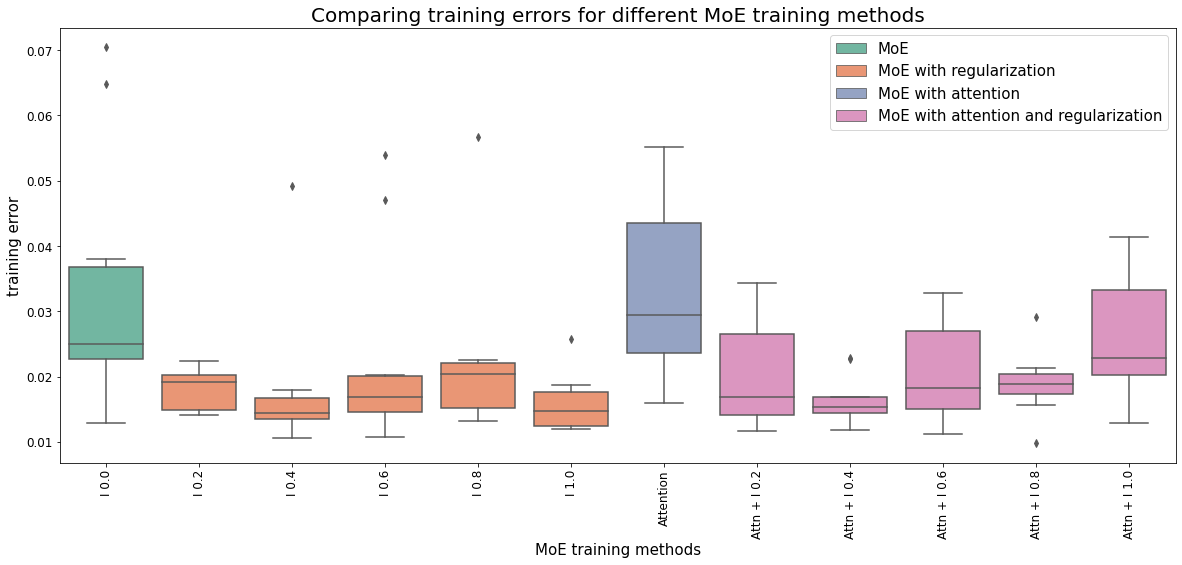

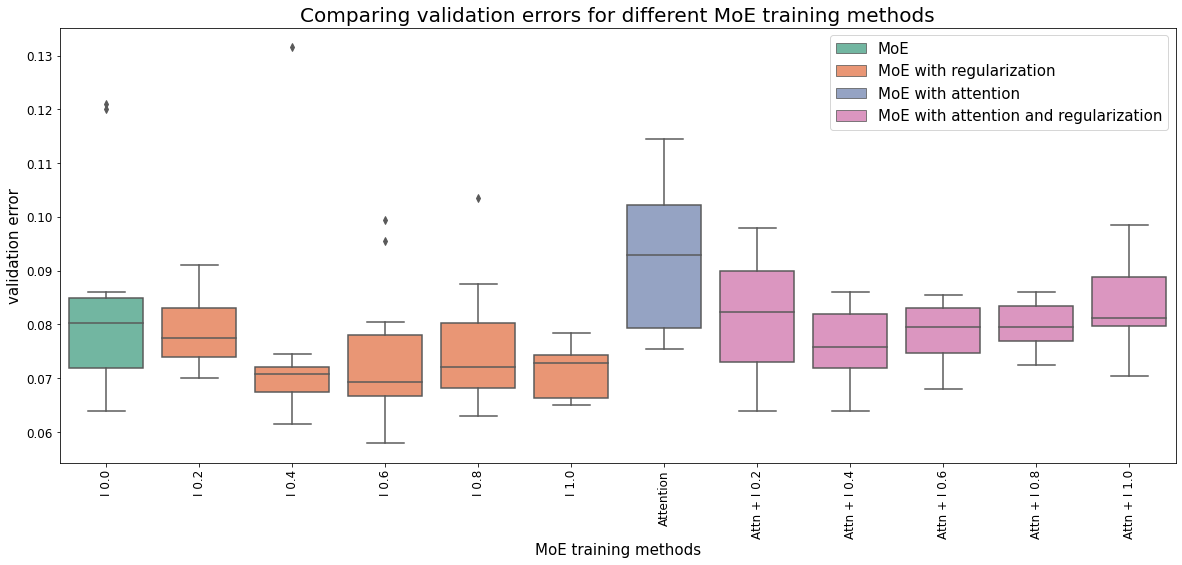

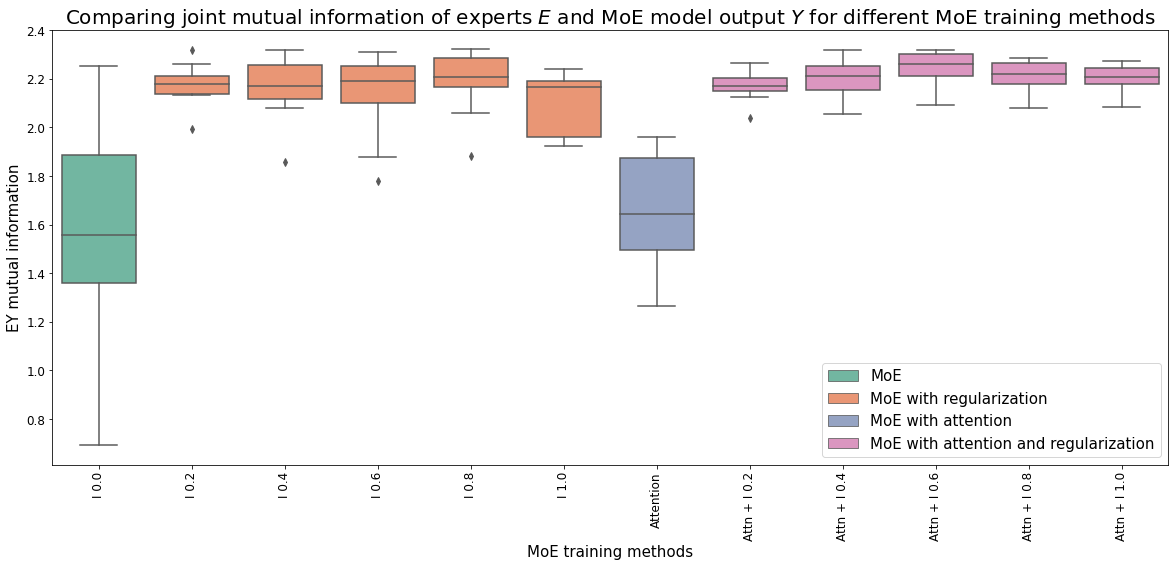

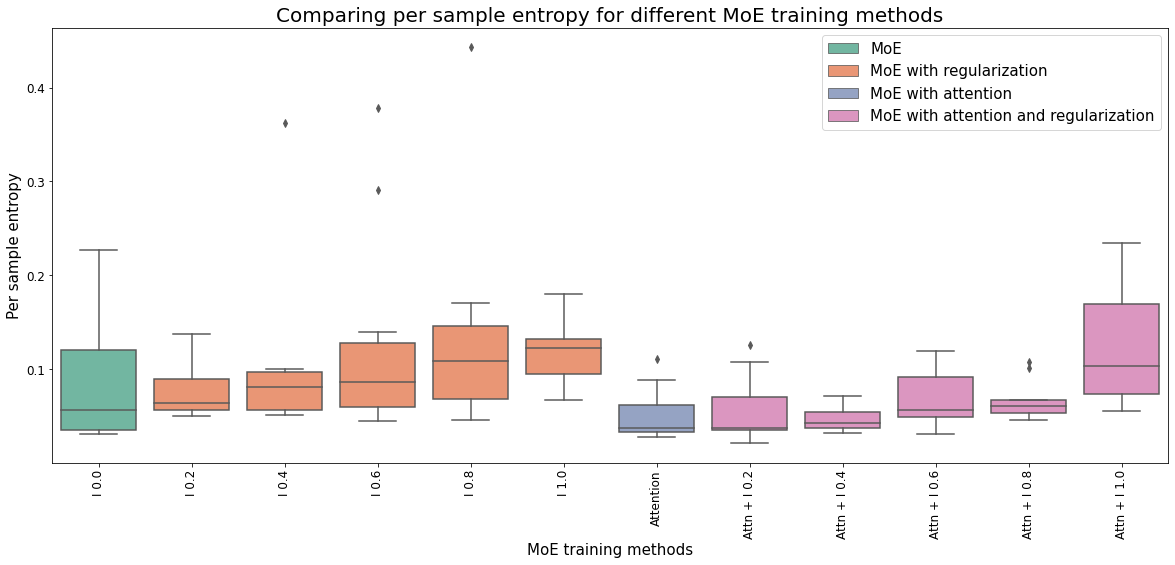

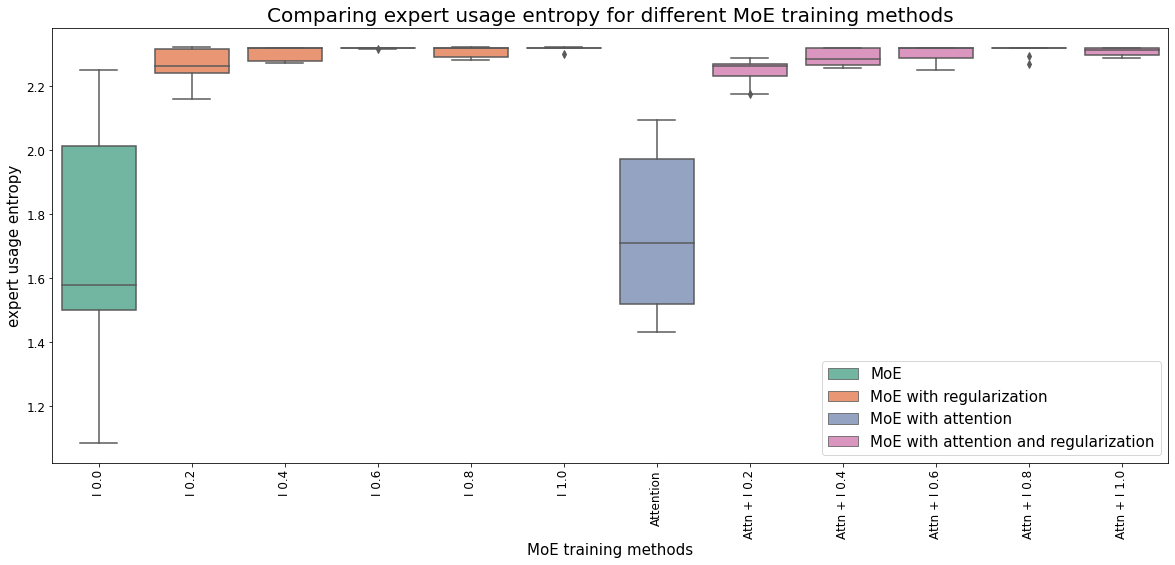

In [66]:
model_without_reg =  model_sample_sim_reg = 'mnist_transform_without_reg'
model_with_reg = 'mnist_transform_with_reg'
model_with_attention = 'mnist_with_attention'
model_with_attn_reg = 'mnist_with_attn_reg'
# model_dual_temp_with_attention = 'mnist_dual_temp_with_attention'
# model_with_temp = 'mnist_dual_temp'
# model_with_reg_temp = 'mnist_dual_temp_with_reg_test'
# mnist_attn_output_reg = 'mnist_attn_output_reg'

total_experts = 5
num_classes = 10

temps = [1.1,1.2]
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 21, 2), np.arange(25, 51, 5)))
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 7, 2)))
temps = np.arange(1.1,1.6,0.1)
print(temps)
w_importance_range = [i * 0.2 for i in range(1, 6)]
print(w_importance_range)

boxplot(
        model_with_reg=model_with_reg, model_without_reg=model_without_reg, 
        model_with_attention=model_with_attention,
        model_with_attn_reg=model_with_attn_reg, 
        temps=temps,w_importance_range=w_importance_range,
        total_experts=total_experts, num_classes=num_classes, classes=range(num_classes), 
        testloader=testloader, figname='mnist_attentive_gate')

In [ ]:
model_single = 'mnist_single_model'
model_with_attention =  'mnist_with_attention'
model_with_temp = 'mnist_dual_temp'
model_with_reg_temp = 'mnist_dual_temp_with_regularization'
model_with_temp_decay = 'mnist_dual_temp_on_schedule'
model_with_reg = 'mnist_with_regularization'
model_without_reg = 'mnist_without_regularization'

total_experts = 5
num_classes = 10

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 6)))
temps = [1.2, 2.0]
w_importance_range = [i * 0.2 for i in range(1, 6)]

boxplot(model_single, model_with_attention, model_with_temp, model_with_temp_decay, model_with_reg, model_without_reg, model_with_reg_temp, temps,w_importance_range,
             total_experts, num_classes, range(num_classes), testloader)

In [ ]:
model_single = 'imbalanced_mnist_single_model'
model_with_temp = 'mnist_imbalanced_5_dual_temp'
model_with_temp_on_delay = 'mnist_imbalanced_5_dual_temp_on_schedule'
model_with_reg = 'mnist_imbalanced_5_with_regularization'
model_without_reg = 'mnist_imbalanced_5_without_regularization'
model_with_reg_temp = 'mnist_imbalanced_5_dual_temp_with_regularization'
total_experts = 5
num_classes = 10

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 6)))
temps = [1.2, 2.0]
w_importance_range = [i * 0.2 for i in range(1, 6)]

boxplot(model_single, model_with_temp, model_with_temp_on_delay, model_with_reg, model_without_reg, model_with_reg_temp, temps,w_importance_range,
             total_experts, num_classes, range(num_classes), testloader)

<Figure size 432x288 with 0 Axes>

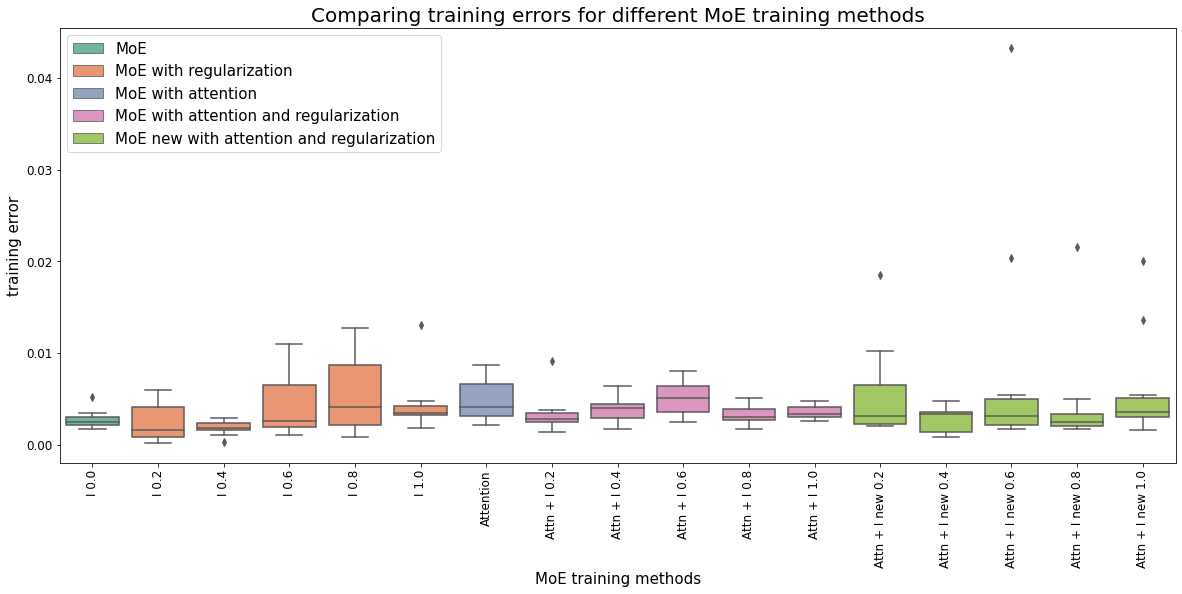

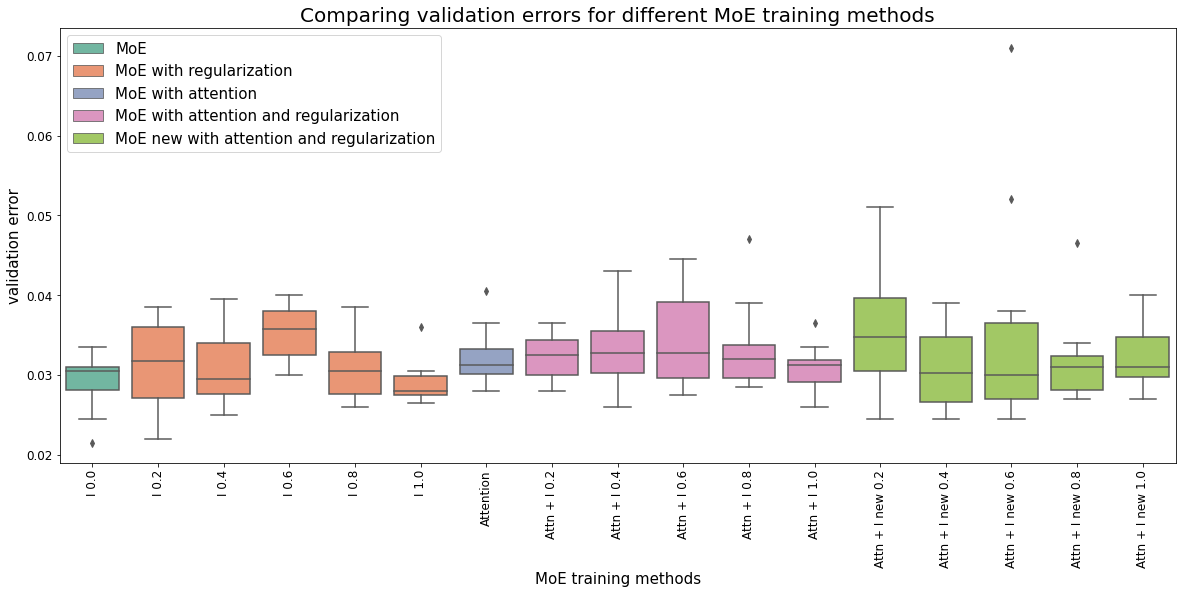

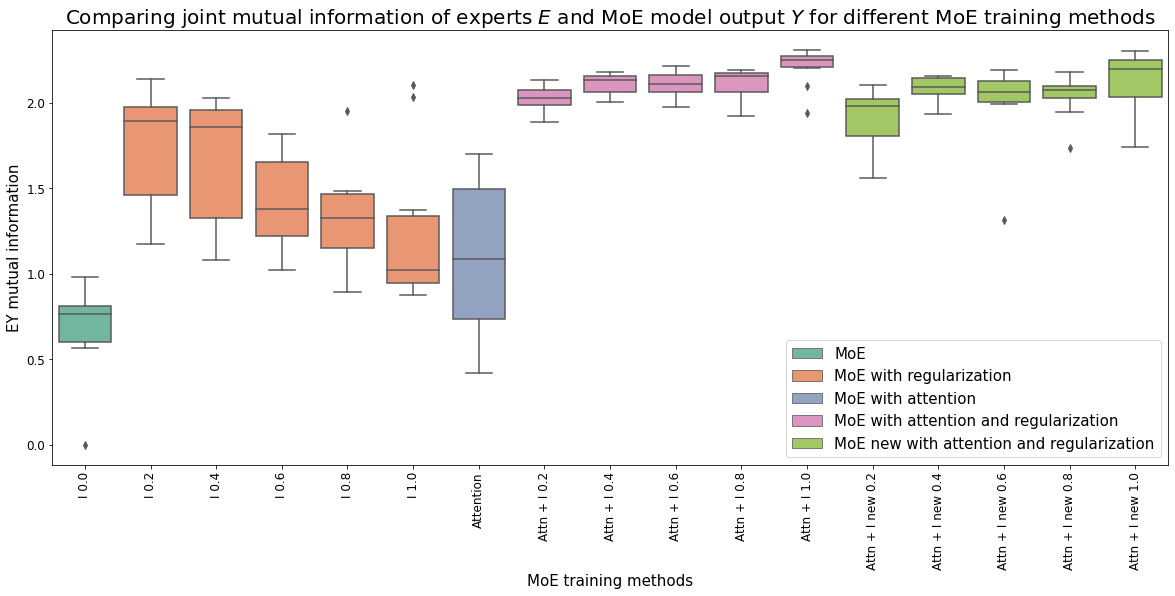

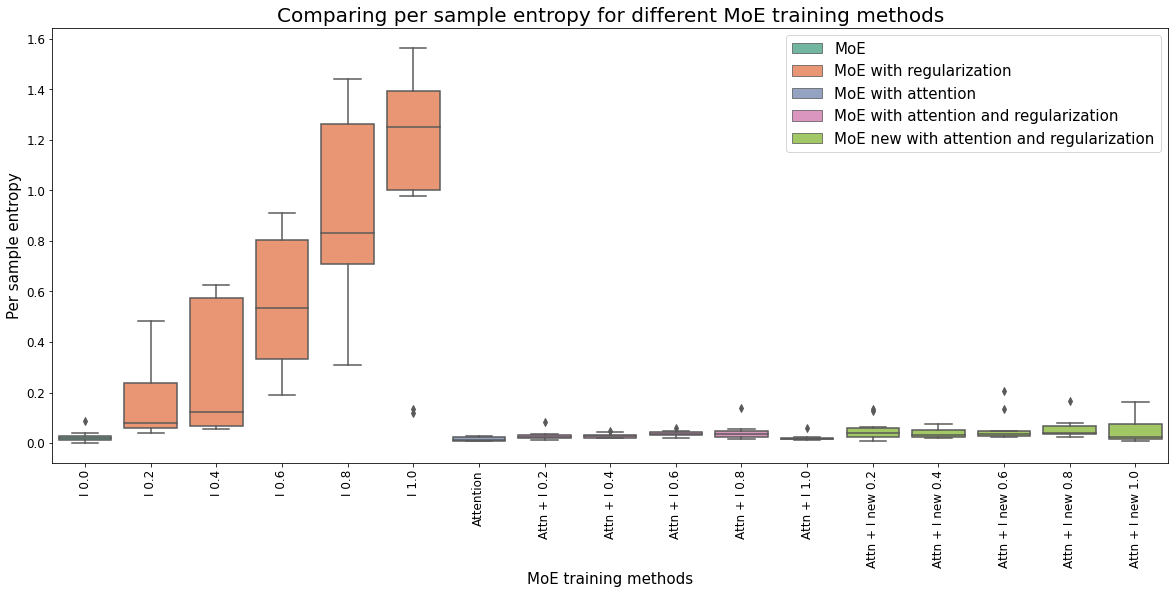

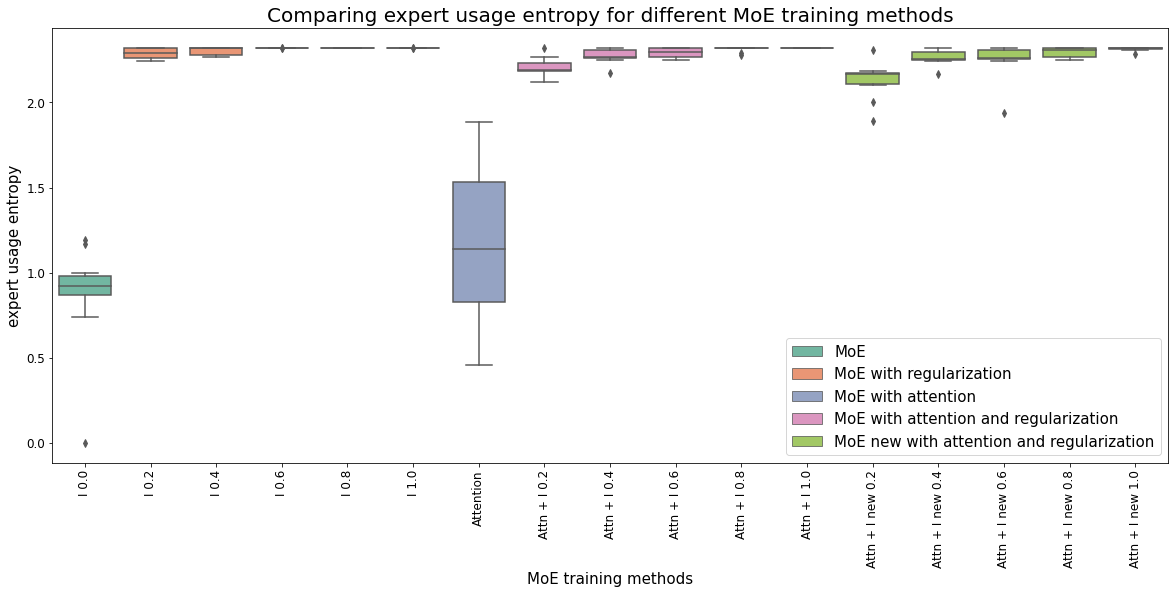

In [54]:
model_with_attention = {'ignore':'rot_mnist_with_attention_hidden_32'}
model_with_attn_reg = {'ignore':'rot_mnist_with_attn_reg_hidden_32', 'new':'new_rot_mnist_with_attn_reg_hidden_32'}
model_with_reg = {'ignore':'rot_mnist_with_reg_hidden_32'}
model_without_reg = {'ignore':'rot_mnist_without_reg_hidden_32'}

figname='rot_mnist_with_attention_hidden_32' 

total_experts = 5
num_classes = 10

w_importance_range = [i * 0.2 for i in range(1, 6)]

boxplot(model_with_reg=model_with_reg, model_without_reg=model_without_reg, model_with_attention=model_with_attention, model_with_attn_reg=model_with_attn_reg,
        w_importance_range=w_importance_range, total_experts=total_experts, num_classes=num_classes, classes=classes_rot_unrot_mnist, 
        testloader=rot_unrot_testloader, figname=figname , fig_path=fig_path, model_path=model_path)

<Figure size 432x288 with 0 Axes>

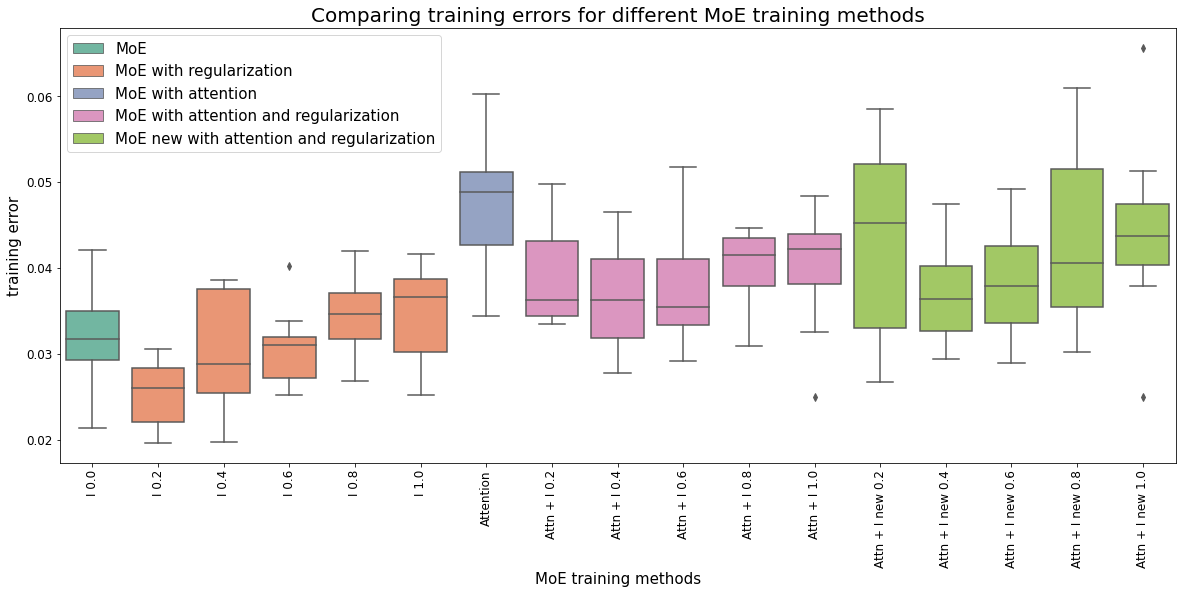

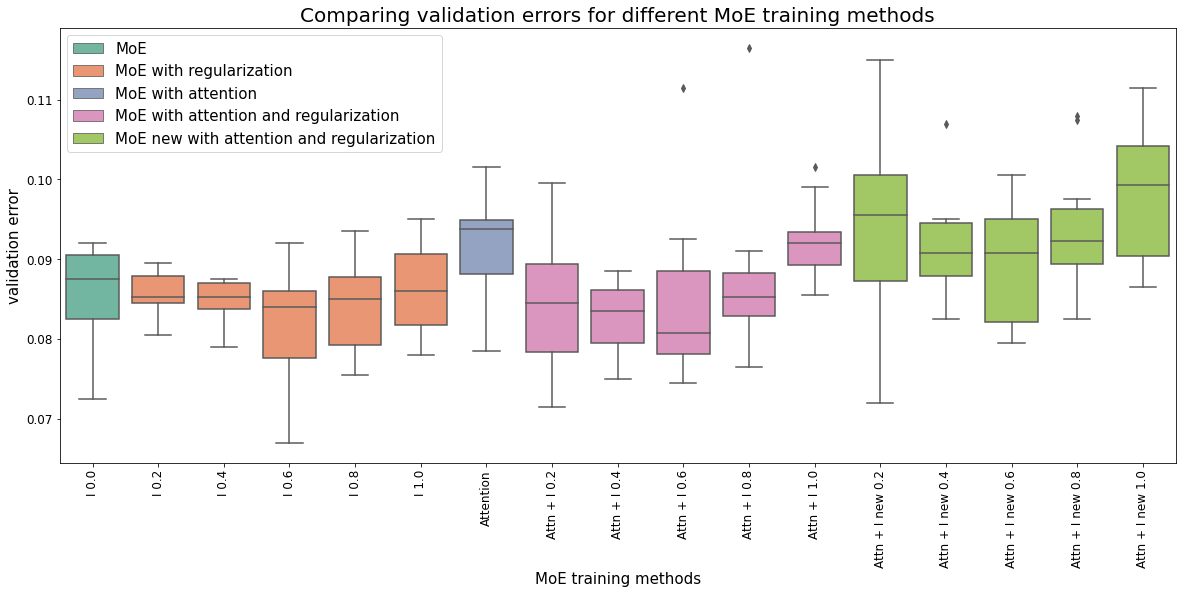

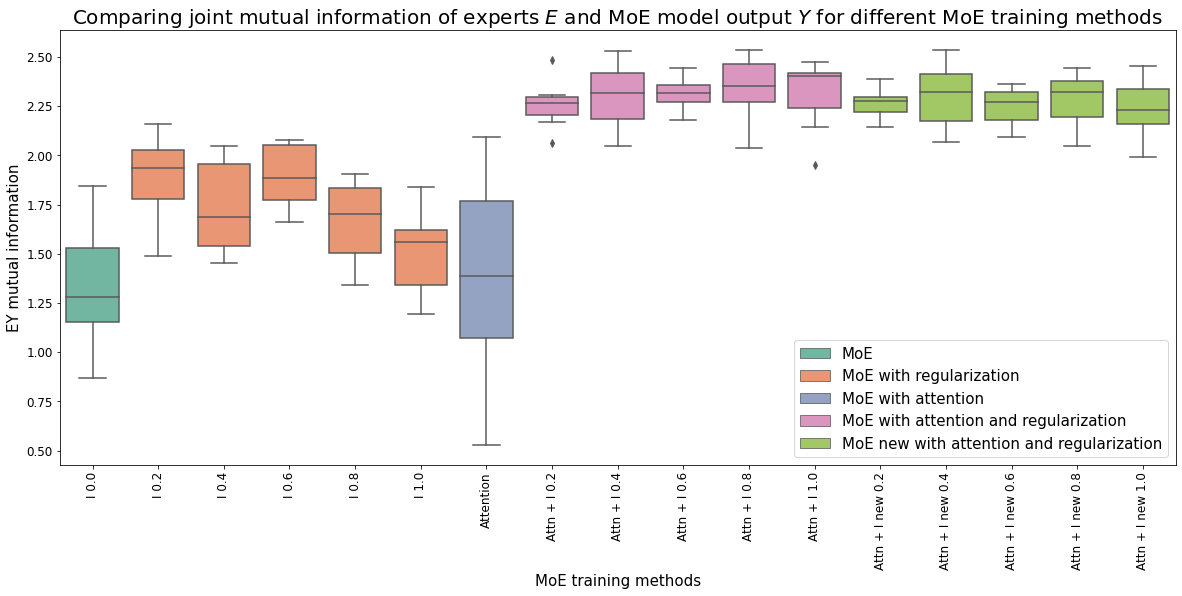

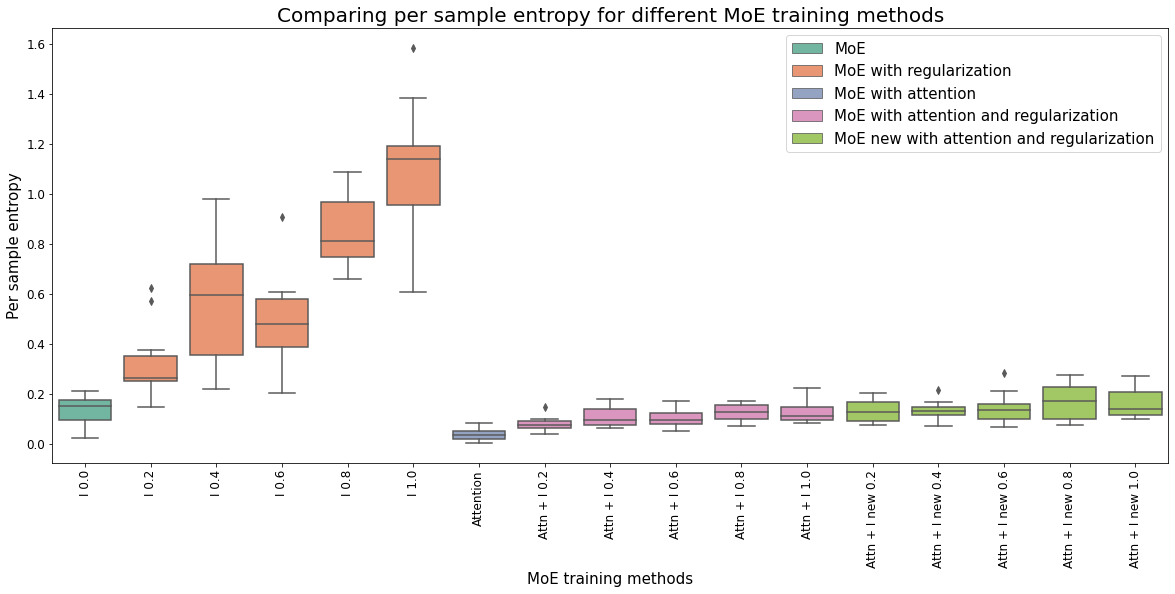

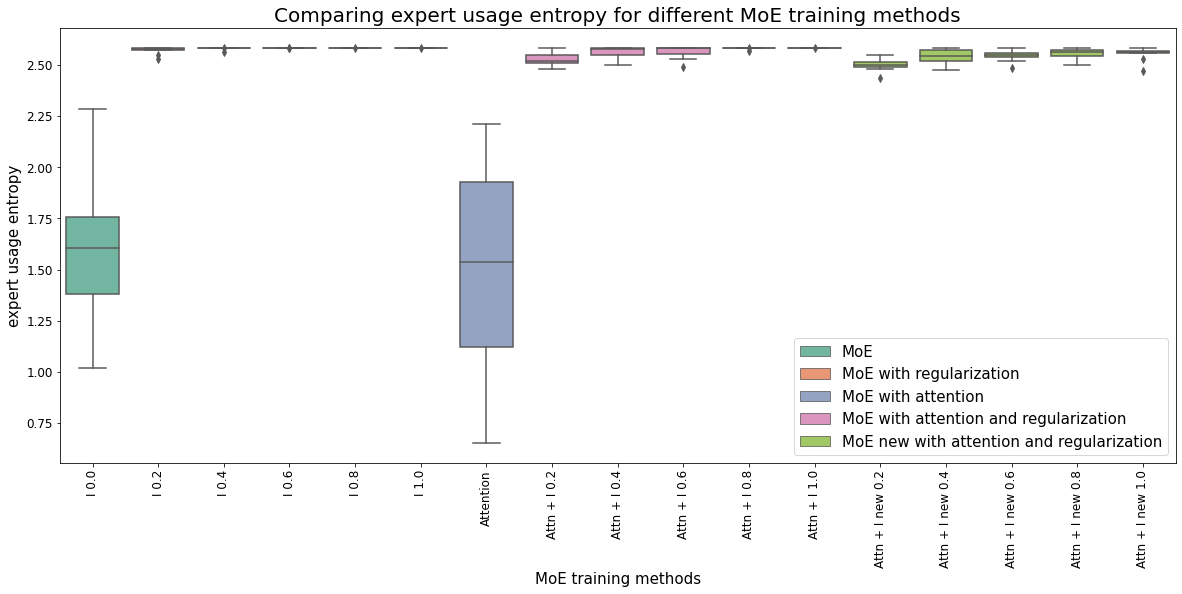

In [91]:
model_with_reg = {'ignore':'fmnist_mnist_with_reg_hidden_32'}
model_without_reg = {'ignore':'fmnist_mnist_without_reg_hidden_32'}
model_with_attention = {'ignore':'fmnist_mnist_with_attention_hidden_32'}
model_with_attn_reg = {'ignore':'fmnist_mnist_with_attn_reg_hidden_32','new':'new_fmnist_mnist_with_attn_reg_hidden_32'}

figname = 'fmnist_mnist_with_attention_hidden_32'
total_experts = 6

w_importance_range = [i * 0.2 for i in range(1, 6)]

boxplot(model_with_reg=model_with_reg, model_without_reg=model_without_reg, model_with_attention=model_with_attention, model_with_attn_reg=model_with_attn_reg,
        w_importance_range=w_importance_range, total_experts=total_experts, num_classes=num_classes_fmnist_mnist, classes=classes_fmnist_mnist, testloader=fmnist_mnist_testloader,
       figname=figname, fig_path=fig_path, model_path=model_path)

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_results(model_with_temp, model_with_reg, model_without_reg, temps, w_importance_range,
                 total_experts, num_classes, classes, testloader):
    
    num_epochs = 20

    min_values = []
    max_values = []
    mean_values = []
    std_values = []
    mutual_info = []
    models = []

    w_importance = 0.0

    for T in temps:    

        m = model_with_temp

        plot_file = generate_plot_file(m, w_importance,'temp_'+"{:.1f}".format(T)+'_'+str(num_classes)+'_'+str(total_experts)+'_models.pt')


        # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
        # model you build above
        model_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)

        print('Model:', plot_file)

        error_values = []
        for model in model_1:
            for e_key, e_val in model.items():
                history = model[e_key]['experts'][total_experts]['history']
                error = 1-np.asarray(history['accuracy'])
                error_values.append(error[-1])

        models.append(model_1[np.argmin(error_values)])

        min_values.append("{:.3f}".format(min(error_values)))
        max_values.append("{:.3f}".format(max(error_values)))
        mean_values.append("{:.3f}".format(mean(error_values)))
        std_values.append("{:.3f}".format(np.std(error_values)))
        mutual_info.append("{:.3f}".format(history['mutual_EY'][-1]))

    T = [ 'T '+"{:.1f}".format(t) for t in temps]
    N_T = len(T)

    for w_importance in w_importance_range:

        m = model_with_reg

        plot_file = generate_plot_file(m, w_importance, str(num_classes)+'_'+str(total_experts)+'_models.pt')


        # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
        # model you build above
        model_2 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
        print('Model:', plot_file)

        error_values = []
        for model in model_2:
            for e_key, e_val in model.items():
                history = model[e_key]['experts'][total_experts]['history']
                error = 1-np.asarray(history['accuracy'])
                error_values.append(error[-1])

        models.append(model_2[np.argmin(error_values)])
#         models.append(model_2[-1])

        min_values.append("{:.3f}".format(min(error_values)))
        max_values.append("{:.3f}".format(max(error_values)))
        mean_values.append("{:.3f}".format(mean(error_values)))
        std_values.append("{:.3f}".format(np.std(error_values)))
        mutual_info.append("{:.3f}".format(history['mutual_EY'][-1]))

    N_I = len(w_importance_range)
    I = [ 'I '+"{:.1f}".format(i) for i in w_importance_range]

    m = model_without_reg

    plot_file = generate_plot_file(m, 0.0, str(num_classes)+'_'+str(total_experts)+'_models.pt')


    # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
    # model you build above
    model_3 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
    print('Model:', plot_file)

    error_values = []
    for model in model_3:
        history = model[e_key]['experts'][total_experts]['history']
        for e_key, e_val in model.items():
            error = 1-np.asarray(history['accuracy'])
            error_values.append(error[-1])

    models.append(model_3[np.argmin(error_values)])
#     models.append(model_3[-1])
    
    min_values.append("{:.3f}".format(min(error_values)))
    max_values.append("{:.3f}".format(max(error_values)))
    mean_values.append("{:.3f}".format(mean(error_values)))
    std_values.append("{:.3f}".format(np.std(error_values)))
    mutual_info.append("{:.3f}".format(history['mutual_EY'][-1]))

    method = T + I + ['I 0.0']
    N = N_T + N_I + 1

    print('N',N)
    data = np.hstack((np.asarray(method).reshape(N,1), np.asarray(min_values).reshape(N,1), np.asarray(max_values).reshape(N,1), 
                      np.asarray(mean_values).reshape(N,1), np.asarray(std_values).reshape(N,1), 
                      np.asarray(mutual_info).reshape(N,1)))

    print(data.shape)

    columns = ['Method', 'Min', 'Max', 'Mean', 'Std', 'Mutual Info']
    colors = np.array([['w']*len(columns)]*N)
    colors[np.argmin(data[:,1]), 1] = 'y'
    colors[np.argmax(data[:,2]), 2] = 'y'
    colors[np.argmin(data[:,3]), 3] = 'y'
    colors[np.argmin(data[:,4]), 4] = 'y'
    colors[np.argmax(data[:,5]), 5] = 'y'

    fig, ax = plt.subplots()
    # hide axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    ax.table(cellText=data, colLabels=columns, cellColours=colors, loc='center')

    fig.tight_layout()

    plt.show()


    model = models[np.argmin(data[0:N_T,1])]

    fig1,ax1 = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12, 4))
    ax1.flatten()

    # Plotting for the model with reg
    for e_key, e_val in model.items():


        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                moe_model = e_val['experts'][total_experts]['model']

                # predict the classes for test data
                pred = moe_model(images)
                pred_labels = torch.argmax(pred, dim=1)

                expert_outputs = moe_model.expert_outputs
                gate_outputs = moe_model.gate_outputs

                # get the experts selected by the gate for each sample
                pred_gate_labels = torch.argmax(gate_outputs, dim=1)

                # plot the expert selection table
                print('\nExperts used by the gate for classification of each digit')
                class_expert_table = np.asarray([[0] * num_classes]*total_experts)
                for label, expert in zip(labels, pred_gate_labels):
                    class_expert_table[expert,label] += 1
                sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], 
                            xticklabels=[classes[i] for i in range(0, num_classes)],
                            annot=True, cmap=cmap, fmt='d', ax=ax1[0])

                sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax1[1], cmap=cmap, fmt='d')

                plt.show()


    model = models[N_T+np.argmin(data[N_T:N-1,1])]
    
    fig1,ax1 = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12, 4))
    ax1.flatten()

    # Plotting for the model without reg
    for e_key, e_val in model.items():
        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                moe_model = e_val['experts'][total_experts]['model']

                # predict the classes for test data
                pred = moe_model(images)
                pred_labels = torch.argmax(pred, dim=1)

                expert_outputs = moe_model.expert_outputs
                gate_outputs = moe_model.gate_outputs

                # get the experts selected by the gate for each sample
                pred_gate_labels = torch.argmax(gate_outputs, dim=1)

                # plot the expert selection table
                print('\nExperts used by the gate for classification of each digit')
                class_expert_table = np.asarray([[0] * num_classes]*total_experts)
                for label, expert in zip(labels, pred_gate_labels):
                    class_expert_table[expert,label] += 1
                sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], 
                            xticklabels=[classes[i] for i in range(0, num_classes)],
                            annot=True, cmap=cmap, fmt='d', ax=ax1[0])

                sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax1[1], cmap=cmap, fmt='d')

                plt.show()

    model = models[-1]

    fig1,ax1 = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12, 4))
    ax1.flatten()

    # Plotting for the model without reg
    for e_key, e_val in model.items():
        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                moe_model = e_val['experts'][total_experts]['model']

                # predict the classes for test data
                pred = moe_model(images)
                pred_labels = torch.argmax(pred, dim=1)

                expert_outputs = moe_model.expert_outputs
                gate_outputs = moe_model.gate_outputs

                # get the experts selected by the gate for each sample
                pred_gate_labels = torch.argmax(gate_outputs, dim=1)

                # plot the expert selection table
                print('\nExperts used by the gate for classification of each digit')
                class_expert_table = np.asarray([[0] * num_classes]*total_experts)
                for label, expert in zip(labels, pred_gate_labels):
                    class_expert_table[expert,label] += 1
                sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], 
                            xticklabels=[classes[i] for i in range(0, num_classes)],
                            annot=True, cmap=cmap, fmt='d', ax=ax1[0])

                sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax1[1], cmap=cmap, fmt='d')

                plt.show()

    # plot error rates
    fig2,ax2 = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(16,4))
    ax2 = ax2.flatten()

    fig3,ax3 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))

    fig4,ax4 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))
    
    fig5,ax5 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))

    for i, model in enumerate(models):
        for e_key, e_val in model.items():

            # plot training and validation error rates
            sns.lineplot(x=range(num_epochs), y=1-np.asarray(model[e_key]['experts'][total_experts]['history']['accuracy']), ax=ax2[0])
            sns.lineplot(x=range(num_epochs), y=1-np.asarray(model[e_key]['experts'][total_experts]['history']['val_accuracy']), ax=ax2[1])

            # plot training loss
            sns.lineplot(x=range(num_epochs), y=np.asarray(model[e_key]['experts'][total_experts]['history']['loss']), ax=ax3)

            # plot mutual information
            sns.lineplot(x=range(num_epochs), y=np.asarray(model[e_key]['experts'][total_experts]['history']['mutual_EY']), ax=ax4)

            # plot mutual information
            sns.lineplot(x=range(num_epochs), y=np.asarray(model[e_key]['experts'][total_experts]['history']['H_EY']), ax=ax5)

    legend = data[:,0]

    ax2[0].legend(legend)

    ax2[0].set_xlabel('epochs')
    ax2[0].set_xticks(range(num_epochs+1))
    ax2[0].set_ylabel('train error rate')
    ax2[0].set_ylim(ymin=0)


    ax2[1].legend(legend)

    ax2[1].set_xlabel('epochs')
    ax2[1].set_xticks(range(num_epochs+1))
    ax2[1].set_ylabel('validation error rate')
    ax2[1].set_ylim(ymin=0)


    ax3.legend(legend)

    ax3.set_xlabel('epochs')
    ax3.set_xticks(range(num_epochs+1))
    ax3.set_ylabel('training loss')
    ax3.set_ylim(ymin=0)

    ax4.legend(legend)

    ax4.set_xlabel('epochs')
    ax4.set_xticks(range(num_epochs+1))
    ax4.set_ylabel('mutual information')
    ax4.set_ylim(ymin=0)
    
    ax5.legend(legend)

    ax5.set_xlabel('epochs')
    ax5.set_xticks(range(num_epochs+1))
    ax5.set_ylabel('Entropy EY')
    ax5.set_ylim(ymin=0)

    plt.show()


### Results for MNIST data

In [ ]:
model_with_temp = 'mnist_dual_temp'
model_with_reg = 'mnist_with_regularization'
model_without_reg = 'mnist_without_regularization'
total_experts = 5
num_classes = 10
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]

plot_results(model_with_temp, model_with_reg, model_without_reg, temps,w_importance_range,
             total_experts, num_classes, range(num_classes), testloader)

In [ ]:
model_with_temp = 'mnist_imbalanced_5_dual_temp'
model_with_reg = 'mnist_imbalanced_5_with_regularization'
model_without_reg = 'mnist_imbalanced_5_without_regularization'
total_experts = 5
num_classes = 10

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]

plot_results(model_with_temp, model_with_reg, model_without_reg, temps,w_importance_range,
             total_experts, num_classes, range(num_classes), testloader)

In [ ]:
model_with_temp = 'rot_mnist_dual_temp'
model_with_reg = 'rot_mnist_with_regularization'
model_without_reg = 'rot_mnist_without_regularization'
total_experts = 5
num_classes = 10

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]

rot_unrot_mnist_classes = ['0','1','2','3','4','rotated 0', 'rotated 1', 'rotated 2', 'rotated 3', 'rotated 4']
plot_results(model_with_temp, model_with_reg, model_without_reg, temps, w_importance_range,
             total_experts, num_classes,rot_unrot_mnist_classes , rot_unrot_testloader)

### Results for combined FMNIST and MNIST data

In [ ]:
model_with_temp = 'fmnist_mnist_dual_temp'
model_with_reg = 'fmnist_mnist_with_regularization'
model_without_reg = 'fmnist_mnist_without_regularization'
total_experts = 6

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]

plot_results(model_with_temp, model_with_reg, model_without_reg, temps, w_importance_range,
             total_experts, num_classes_fmnist_mnist, classes_fmnist_mnist, fmnist_mnist_testloader)

In [ ]:
def plot_gate_prob(model_with_temp, model_with_reg, model_without_reg, temps, w_importance_range,
                 total_experts, num_classes, classes, testloader):
    
    w_importance = 0.0
    
    for T in temps:    

        m = model_with_temp

        plot_file = generate_plot_file(m, w_importance,'temp_'+"{:.1f}".format(T)+'_'+str(num_classes)+'_'+str(total_experts)+'_models.pt')


        # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
        # model you build above
        model = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)[5]
        
        for e_key, e_val in model.items():
            history = model[e_key]['experts'][total_experts]['history']
            mean_gate_probability = np.asarray(history['mean_gate_probability'])
            var_gate_probability = np.asarray(history['var_gate_probability'])
            print('Temperature ', "{:.1f}".format(T))
            print(mean_gate_probability.shape)
            plt.imshow(np.transpose(mean_gate_probability))
            plt.show()
            plt.imshow(np.transpose(var_gate_probability))
            plt.show()
        
    

#     for w_importance in w_importance_range:

#         m = model_with_reg

#         plot_file = generate_plot_file(m, w_importance, str(num_classes)+'_'+str(total_experts)+'_models.pt')


#         # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
#         # model you build above
#         model_2 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
# #         print('Model:', plot_file)

#         error_values = []
#         for model in model_2:
#             for e_key, e_val in model.items():
#                 history = model[e_key]['experts'][total_experts]['history']
#                 error = 1-np.asarray(history['accuracy'])
#                 val_error = 1-np.asarray(history['val_accuracy'])
#                 y_error.append(error[-1])
#                 y_val_error.append(val_error[-1])
#                 y_mi.append(history['mutual_EY'][-1])
#                 y_H_EY.append(history['H_EY'][-1])
#                 y_sample_H.append(history['sample_entropy'][-1])
#                 x.append('I '+"{:.1f}".format(w_importance))


In [ ]:
model_with_temp = 'fmnist_mnist_dual_temp'
model_with_reg = 'fmnist_mnist_with_regularization'
model_without_reg = 'fmnist_mnist_without_regularization'
total_experts = 6
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]
plot_gate_prob(model_with_temp, model_with_reg, model_without_reg, temps,w_importance_range,
             total_experts, num_classes_fmnist_mnist, classes_fmnist_mnist, fmnist_mnist_testloader)